# Notebook for Visualizing and Analyzing QC/NBD Data

Written by L.F. Heald 2024

In [42]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.special
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter as gf
import pandas as pd
from scipy.optimize import curve_fit, dual_annealing, differential_evolution
from scipy.special import erf

import h5py
import re
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Degrees of freedom <= 0 for slice')

angs = '\u00C5' # Angstrom sign
path_mol='packages/Molecular_coordinates/' # The molecular .xyz/.csv paths


## Import Experimental Data
Reads data from previously existing matlab files

In [8]:
folder_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\"

variable = "delay_all_cut"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
time_exp = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {time_exp.shape}")
time_new = time_exp[:-4] - ((82.45+15.6)/1000)

variable = "dI_I_all_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
simu_all = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {simu_all.shape}")

variable = "dI_I_all_simu_slow"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
simu_slow = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {simu_slow.shape}")

# variable = "dI_I_s1_ab_init"
# # variable = "A_smooth"
# mat_file = folder_path + variable + ".mat"
# # mat = h5py.File(mat_file, 'r')
# s1_e_scattering = np.array(mat.get(variable))
# print(f"{variable} has a shape of {s1_e_scattering.shape}")

variable = "dI_I_end_all_mean_2D_smooth"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
dI_I_smooth = np.array(mat.get(variable)).T
print(f"{variable} has a shape of {dI_I_smooth.shape}")

variable = "s_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
s_simu = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {s_simu.shape}")

variable = "delay_simu"
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
time_simu = np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {time_simu.shape}")

variable = 'dI_I_frags'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
frag_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {frag_simu.shape}")

variable = 'dI_I_CP_C2H2'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
frag_alt= np.squeeze(np.array(mat.get(variable)))
print(f"{variable} has a shape of {frag_alt.shape}")

variable = 'dI_I_NBD'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
NBD_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {NBD_simu.shape}")

variable = 'dI_I_QC'
mat_file = folder_path + variable + ".mat"
mat = h5py.File(mat_file, 'r')
QC_simu = np.mean(np.array(mat.get(variable)), axis=1)
print(f"{variable} has a shape of {QC_simu.shape}")

import scipy.io # needed to do it this way because of an outdated version of matlab and how it creates .mat files

A_smooth = scipy.io.loadmat((folder_path + "A_smooth.mat"))
#print(A_smooth.keys())

fit_params = scipy.io.loadmat((folder_path + "all_fit_info.mat"))

dI_I_boot = A_smooth["A_smooth"]
print("dI_I_boot has a shape of ", dI_I_boot.shape)

s1_e_scattering = scipy.io.loadmat((folder_path + "dI_I_s1_ab_init.mat"))
s1_e_scattering = np.squeeze(np.array(s1_e_scattering['dI_I_test_S1']))

s2_e_scattering = scipy.io.loadmat((folder_path + "dI_I_s2_ab_init.mat"))
s2_e_scattering = np.squeeze(np.array(s2_e_scattering['dI_I_test_S2']))

s3_e_scattering = scipy.io.loadmat((folder_path + "dI_I_s3_ab_init.mat"))
s3_e_scattering = np.squeeze(np.array(s3_e_scattering['dI_I_test_S3']))

e_scat_s = scipy.io.loadmat((folder_path + "e_scat_s.mat"))
e_scat_s = np.squeeze(np.array(e_scat_s['qq']))
print(e_scat_s.shape)



# print(s_temp.shape)
# print(frag_dI_new.shape)

# e_scattering_mean = np.squeeze(np.mean((s3_e_scattering, s2_e_scattering, s1_e_scattering), axis=0))
# print(e_scattering_mean.shape)

delay_all_cut has a shape of (25,)
dI_I_all_simu has a shape of (2000, 412)
dI_I_all_simu_slow has a shape of (2000, 412)
dI_I_end_all_mean_2D_smooth has a shape of (412, 25)
s_simu has a shape of (412,)
delay_simu has a shape of (2000,)
dI_I_frags has a shape of (412,)
dI_I_CP_C2H2 has a shape of (412,)
dI_I_NBD has a shape of (412,)
dI_I_QC has a shape of (412,)
dI_I_boot has a shape of  (412, 25, 100)
(101,)


## Load Trajectory Data
Loads in data from an h5 file that was create using the `Process_Trajectories.py` program that takes xyz trajectory files and calculates scattering patterns for each structure

In [3]:
inv_angs = '($\mathrm{\AA}^{-1}$)'
angs = '($\mathrm\{\AA})'

def load_trajectory_h5(file_name, group_name):
    """
    Reads an HDF5 file and groups datasets by their numeric run ID (e.g., '0014').
    
    ARGUMENTS:
    
    file_name (str):
        Name and path to the HDF5 file to read from.
    group_name (str):
        The name of the group to search in the HDF5 file.
    
    RETURNS:
    
    A dictionary where the keys are run IDs (e.g., '0014') and the values 
    are dictionaries with dataset names as keys and the dataset values as NumPy arrays.
    """
    run_dict = defaultdict(dict)  # Dictionary to group datasets by run ID
    
    # Open the HDF5 file
    with h5py.File(file_name, 'r') as f:
        if group_name not in f:
            print(f"Group '{group_name}' not found in the file.")
            return run_dict
        
        group = f[group_name]
        
        # Regex pattern to extract the numeric run ID (e.g., '0014')
        pattern = re.compile(r'run_(\d{4})')
        
        # Loop through the datasets in the group
        for dataset_name in group.keys():
            match = pattern.search(dataset_name)
            if match:
                run_id = match.group(1)  # Extract the numeric run ID (e.g., '0014')
                variable_name = dataset_name.split(f'_run_{run_id}')[0]  # Extract the variable name
                
                dataset = group[dataset_name]
                
                # Check if the dataset is scalar
                if dataset.shape == ():  # Scalar dataset
                    run_dict[run_id][variable_name] = dataset[()]  # Access scalar data
                else:  # Non-scalar dataset (array-like)
                    run_dict[run_id][variable_name] = dataset[:]  # Access array data
            else:
                print(f"Warning: Could not extract run ID from '{dataset_name}'")
    
    return dict(run_dict)  # Convert defaultdict to regular dict


# notes_path = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\"
# notes_name = "NB_CI_crossing_T0_time.txt"

def read_notes(file_path):
    with open(file_path, 'r') as file:
        text = file.readlines()
    
    traj_id = []
    idx = []
    ci_time = []
    t0 = []
    groups = []
    for line in text[1:]:  # Assuming you want to skip the first line
        string = list(map(str, line.split()))
        
        if len(string) < 4:
            continue
        temp = list(map(str, string[0].split('/')))
        traj_id.append(temp[1][5:-1])
        
        if temp[0].lower() == 'singlet_2':
            groups.append('s2')
        elif temp[0].lower() == 'singlet_3':
            groups.append('s3')
        elif temp[0].lower() == 'singlet_4':
            groups.append('s4')
        else:
            continue
        # Convert idx (string[2]) to int or np.nan if 'none'
        if string[2].lower() == 'none':
            idx.append(np.nan)
        else:
            idx.append(int(string[2]))
        
        # Convert ci_time (string[4]) to float or np.nan if 'none'
        if string[4].lower() == 'none':
            ci_time.append(np.nan)
        else:
            ci_time.append(float(string[4]))
        
        # You can extend this for other columns if needed
        # Example for t0 (string[3])
        if string[3].lower() == 'none':
            t0.append(np.nan)
        else:
            t0.append(float(string[3]))

    return groups, traj_id, idx, ci_time, t0

# Example usage:
# traj_id, idx, ci_time, t0 = read_notes('your_file.txt')


# notes_name = notes_path + notes_name
# groups, traj_keys, idx, ci_time, t0_val = read_notes(notes_name)
#h5_file = "C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory \
    #Structures\\NB_Trajectories_2024-09-05.h5"

# for i, group in enumerate(groups):
#     run_number = traj_keys[i]
#     dictionary = {'CI_time':ci_time[i], 't0':t0_val[i], 'idx':idx[i]}
#     gued.add_to_h5(h5_file, group, dictionary, run_number=run_number)
#     time.sleep(1)

### Editing h5 files to add initial state information

Easier to keep things as a dictionary... 

In [6]:
file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "QC_Trajectories_2024-09-05.h5"
print(file_name)
#gt.inspect_h5(file_name)

QC_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s2"))
new_row = pd.DataFrame([["s2"] * len(QC_s2_traj.columns)], columns=QC_s2_traj.columns, index=["init_state"])
QC_s2_df = pd.concat([QC_s2_traj, new_row])

QC_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s3"))
new_row = pd.DataFrame([["s3"] * len(QC_s3_traj.columns)], columns=QC_s3_traj.columns, index=["init_state"])
QC_s3_df = pd.concat([QC_s3_traj, new_row])

QC_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "QC_s4"))
new_row = pd.DataFrame([["s4"] * len(QC_s4_traj.columns)], columns=QC_s4_traj.columns, index=["init_state"])
QC_s4_df = pd.concat([QC_s4_traj, new_row])

QC_df = pd.concat([QC_s2_df, QC_s3_df, QC_s4_df], axis=1)

file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\Theory Structures\\'
file_name = file_path + "NB_Trajectories_2024-09-05.h5"
#print(f"{len(s2_trajectories)} trajectories in this group")

NB_s2_traj = pd.DataFrame(load_trajectory_h5(file_name, "s2"))
new_row = pd.DataFrame([["s2"] * len(NB_s2_traj.columns)], columns=NB_s2_traj.columns, index=["init_state"])
NB_s2_df = pd.concat([NB_s2_traj, new_row])

NB_s3_traj = pd.DataFrame(load_trajectory_h5(file_name, "s3"))
new_row = pd.DataFrame([["s3"] * len(NB_s3_traj.columns)], columns=NB_s3_traj.columns, index=["init_state"])
NB_s3_df = pd.concat([NB_s3_traj, new_row])

NB_s4_traj = pd.DataFrame(load_trajectory_h5(file_name, "s4"))
new_row = pd.DataFrame([["s4"] * len(NB_s4_traj.columns)], columns=NB_s4_traj.columns, index=["init_state"])
NB_s4_df = pd.concat([NB_s4_traj, new_row])

NB_df = pd.concat([NB_s2_df, NB_s3_df, NB_s4_df], axis=1)


C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\QC data and code\Theory Structures\QC_Trajectories_2024-09-05.h5


### Filtering Dictionaries based on CI Time

In [7]:
QC_s2_slow = pd.DataFrame({key: value for key, value in QC_s2_traj.items() if value['CI_time'] >= 300})
print(QC_s2_df.shape)
print(QC_s2_slow.shape)

NB_s2_slow = pd.DataFrame({key: value for key, value in NB_s2_traj.items() if value['CI_time'] >= 300})
print(NB_s2_df.shape)
print(NB_s2_slow.shape)

QC_s3_slow = pd.DataFrame({key: value for key, value in QC_s3_traj.items() if value['CI_time'] >= 300})
print(QC_s3_df.shape)
print(QC_s3_slow.shape)

NB_s3_slow = pd.DataFrame({key: value for key, value in NB_s3_traj.items() if value['CI_time'] >= 300})
print(NB_s3_df.shape)
print(NB_s3_slow.shape)

QC_s4_slow = pd.DataFrame({key: value for key, value in QC_s4_traj.items() if value['CI_time'] >= 300})
print(QC_s4_df.shape)
print(QC_s4_slow.shape)

NB_s4_slow = pd.DataFrame({key: value for key, value in NB_s4_traj.items() if value['CI_time'] >= 300})
print(NB_s4_df.shape)
print(NB_s4_slow.shape)

(9, 38)
(8, 8)
(8, 62)
(7, 8)
(8, 25)
(7, 14)
(8, 53)
(7, 35)
(8, 26)
(7, 16)
(8, 30)
(7, 23)


## Getting Averages of Simulations

In [10]:
# Define multiple ranges
min_s1, max_s1 = 1.06, 1.72
min_s2, max_s2 = 2.2, 2.82
min_s3, max_s3 = 4.85, 5.8
min_s4, max_s4 = 6.7, 7.6

traj_s = NB_s2_traj["0008"]["s"]
time_vals = NB_s2_traj["0008"]["time"] + 145
# Get the indices for each range and concatenate them

traj_indices = np.concatenate([
    np.where((traj_s > min_s1) & (traj_s < max_s1))[0],
    np.where((traj_s > min_s2) & (traj_s < max_s2))[0],
    np.where((traj_s > min_s3) & (traj_s < max_s3))[0], 
    np.where((traj_s > min_s4) & (traj_s < max_s4))[0],
])

exp_indices = np.concatenate([
    np.where((s_simu > min_s1) & (s_simu < max_s1))[0],
    np.where((s_simu > min_s2) & (s_simu < max_s2))[0],
    np.where((s_simu > min_s3) & (s_simu < max_s3))[0], 
    np.where((s_simu > min_s4) & (s_simu < max_s4))[0],
])


In [11]:
# prep data sets after import
filter_sign = 'no'
if filter_sign == 'yes':
    QC_s2 = pd.DataFrame.from_dict(QC_s2_slow)
    QC_s2_weight = QC_s2.shape[1]
    print(f"Number of slow trajectories for QC s2 is {QC_s2_weight}")
    NB_s2 = pd.DataFrame.from_dict(NB_s2_slow)
    NB_s2_weight = NB_s2.shape[1]
    print(f"Number of slow trajectories for NB s2 is {NB_s2_weight}")

    QC_s3 = pd.DataFrame.from_dict(QC_s3_slow)
    QC_s3_weight = QC_s3.shape[1]
    print(f"Number of slow trajectories for QC s3 is {QC_s3_weight}")
    NB_s3 = pd.DataFrame.from_dict(NB_s3_slow)
    NB_s3_weight = NB_s3.shape[1]
    print(f"Number of slow trajectories for NB s3 is {NB_s3_weight}")

    QC_s4 = pd.DataFrame.from_dict(QC_s4_slow)
    QC_s4_weight = QC_s4.shape[1]
    print(f"Number of slow trajectories for QC s4 is {QC_s4_weight}")
    NB_s4 = pd.DataFrame.from_dict(NB_s4_slow)
    NB_s4_weight = NB_s4.shape[1]
    print(f"Number of slow trajectories for NB s4 is {NB_s4_weight}")
    #print(QC_s2)
else:
    QC_s2 = pd.DataFrame.from_dict(QC_s2_traj)
    QC_s2_weight = QC_s2.shape[1]
    print(f"Number of trajectories for QC s2 is {QC_s2_weight}")
    NB_s2 = pd.DataFrame.from_dict(NB_s2_traj)
    NB_s2_weight = NB_s2.shape[1]
    print(f"Number of trajectories for NB s2 is {NB_s2_weight}")

    QC_s3 = pd.DataFrame.from_dict(QC_s3_traj)
    QC_s3_weight = QC_s3.shape[1]
    print(f"Number of trajectories for QC s3 is {QC_s3_weight}")
    NB_s3 = pd.DataFrame.from_dict(NB_s3_traj)
    NB_s3_weight = NB_s3.shape[1]
    print(f"Number of trajectories for NB s3 is {NB_s3_weight}")

    QC_s4 = pd.DataFrame.from_dict(QC_s4_traj)
    QC_s4_weight = QC_s4.shape[1]
    print(f"Number of trajectories for QC s4 is {QC_s4_weight}")
    NB_s4 = pd.DataFrame.from_dict(NB_s4_traj)
    NB_s4_weight = NB_s4.shape[1]
    print(f"Number of trajectories for NB s4 is {NB_s4_weight}")
    #print(QC_s2)


QC_s2_dI = QC_s2.loc["dI_I_raw"].mean().T
QC_s2_dI_conv = (QC_s2.loc["dI_I_conv"].mean().T)/100
QC_s2_dI_conv_all = np.array(QC_s2.loc["dI_I_conv"]/100)
QC_s2_dI_conv_err = np.std(np.array(QC_s2.loc["dI_I_conv"])/100).T
QC_s2_feat_1 = np.sum(np.abs(QC_s2_dI[traj_indices]), axis=0)
QC_s2_feat_1_conv = np.sum(np.abs(QC_s2_dI_conv[traj_indices]), axis=0)
QC_s2_late = np.mean(QC_s2_dI[:, np.where((QC_s2_traj["0014"]["time"] > 1000) & (QC_s2_traj["0014"]["time"] < 1200))[0]], axis=1)
# QC_s2_start = QC_s2_dI[:, np.where((QC_s2_traj["0014"]["time"] == 0))[0]]
# print(QC_s2_start)

QC_s2_mean = np.mean(np.abs(QC_s2_dI), axis=0)
QC_s2_t0s = np.array(QC_s2.loc["t0"])
#print(f"QC s2 t0s shape = {len(QC_s2_t0s)}")
QC_s2_CIs = np.array(QC_s2.loc["CI_time"])
QC_s2_CI = np.nanmean(np.array(QC_s2.loc["CI_time"]))
#print(f"QC s2 CIs shape = {len(QC_s2_CIs)}")

#print(QC_s2_dI.shape)
NB_s2_dI = NB_s2.loc["dI_I_raw"].mean().T
NB_s2_dI_conv = (NB_s2.loc["dI_I_conv"].mean().T)/100
NB_s2_dI_conv_all = np.array(NB_s2.loc["dI_I_conv"]/100)
NB_s2_dI_conv_err = np.std(np.array(NB_s2.loc["dI_I_conv"])/100).T
NB_s2_feat_1 = np.sum(np.abs(NB_s2_dI[traj_indices]), axis=0)
NB_s2_feat_1_conv = np.sum(np.abs(NB_s2_dI_conv[traj_indices]), axis=0)
NB_s2_late = np.mean(NB_s2_dI[:, np.where((NB_s2_traj["0107"]["time"] > 1000) & (NB_s2_traj["0107"]["time"] < 1200))[0]], axis=1)
NB_s2_mean = np.mean(np.abs(NB_s2_dI), axis=0)
NB_s2_t0s = np.array(NB_s2.loc["t0"])
#print(f"NB s2 t0s shape = {len(NB_s2_t0s)}")
NB_s2_CIs = np.array(NB_s2.loc["CI_time"])
NB_s2_CI = np.nanmean(np.array(NB_s2.loc["CI_time"]))
#print(f"NB s2 CIs shape = {len(NB_s2_CIs)}")

QC_s3_dI = QC_s3.loc["dI_I_raw"].mean().T
QC_s3_dI_conv = (QC_s3.loc["dI_I_conv"].mean().T)/100
QC_s3_dI_conv_all = np.array(QC_s3.loc["dI_I_conv"]/100)
QC_s3_dI_conv_err = np.std(np.array(QC_s3.loc["dI_I_conv"])/100).T
QC_s3_feat_1 = np.sum(np.abs(QC_s3_dI[traj_indices]), axis=0)
QC_s3_feat_1_conv = np.sum(np.abs(QC_s3_dI_conv[traj_indices]), axis=0)
QC_s3_late = np.mean(QC_s3_dI[:, np.where((QC_s2_traj["0014"]["time"] > 1000) & (QC_s2_traj["0014"]["time"] < 1200))[0]], axis=1)
QC_s3_mean = np.mean(np.abs(QC_s3_dI), axis=0)
QC_s3_t0s = np.array(QC_s3.loc["t0"])
#print(f"QC s3 t0s shape = {len(QC_s3_t0s)}")
QC_s3_CIs = np.array(QC_s3.loc["CI_time"])
QC_s3_CI = np.nanmean(np.array(QC_s3.loc["CI_time"]))
#print(f"QC s3 CIs shape = {len(QC_s3_CIs)}")

NB_s3_dI = NB_s3.loc["dI_I_raw"].mean().T
NB_s3_dI_conv = (NB_s3.loc["dI_I_conv"].mean().T)/100
NB_s3_dI_conv_all = np.array(NB_s3.loc["dI_I_conv"]/100)
NB_s3_dI_conv_err = np.std(np.array(NB_s3.loc["dI_I_conv"])/100).T
NB_s3_feat_1 = np.sum(np.abs(NB_s3_dI[traj_indices]), axis=0)
NB_s3_feat_1_conv = np.sum(np.abs(NB_s3_dI_conv[traj_indices]), axis=0)
NB_s3_late = np.mean(NB_s3_dI[:, np.where((NB_s2_traj["0107"]["time"] > 1000) & (NB_s2_traj["0107"]["time"] < 1200))[0]], axis=1)
NB_s3_mean = np.mean(np.abs(NB_s3_dI), axis=0)
NB_s3_t0s = np.array(NB_s3.loc["t0"])
#print(f"NB s3 t0s shape = {len(NB_s3_t0s)}")
NB_s3_CIs = np.array(NB_s3.loc["CI_time"])
NB_s3_CI = np.nanmean(np.array(NB_s3.loc["CI_time"]))
#print(f"NB s3 CIs shape = {len(NB_s3_CIs)}")

QC_s4_dI = QC_s4.loc["dI_I_raw"].mean().T
QC_s4_dI_conv = (QC_s4.loc["dI_I_conv"].mean().T)/100
QC_s4_dI_conv_all = np.array(QC_s4.loc["dI_I_conv"]/100)
QC_s4_dI_conv_err = np.std(np.array(QC_s4.loc["dI_I_conv"])/100).T
QC_s4_feat_1 = np.sum(np.abs(QC_s4_dI[traj_indices]), axis=0)
QC_s4_feat_1_conv = np.sum(np.abs(QC_s4_dI_conv[traj_indices]), axis=0)
QC_s4_late = np.mean(QC_s4_dI[:, np.where((QC_s2_traj["0014"]["time"] > 1000) & (QC_s2_traj["0014"]["time"] < 1200))[0]], axis=1)
QC_s4_mean = np.mean(np.abs(QC_s4_dI), axis=0)
QC_s4_t0s = np.array(QC_s4.loc["t0"])
#print(f"QC s4 t0s shape = {len(QC_s4_t0s)}")
QC_s4_CIs = np.array(QC_s4.loc["CI_time"])
QC_s4_CI = np.nanmean(np.array(QC_s4.loc["CI_time"]))
#print(f"QC s4 CIs shape = {len(QC_s4_CIs)}")

#print(QC_s2_dI.shape)
NB_s4_dI = NB_s4.loc["dI_I_raw"].mean().T
NB_s4_dI_conv = (NB_s4.loc["dI_I_conv"].mean().T)/100
NB_s4_dI_conv_all = np.array(NB_s4.loc["dI_I_conv"]/100)
NB_s4_dI_conv_err = np.std(np.array(NB_s4.loc["dI_I_conv"])/100).T
NB_s4_feat_1 = np.sum(np.abs(NB_s4_dI[traj_indices]), axis=0)
NB_s4_feat_1_conv = np.sum(np.abs(NB_s4_dI_conv[traj_indices]), axis=0)
NB_s4_late = np.mean(NB_s4_dI[:, np.where((NB_s2_traj["0107"]["time"] > 1000) & (NB_s2_traj["0107"]["time"] < 1200))[0]], axis=1)

NB_s4_mean = np.mean(np.abs(NB_s4_dI), axis=0)
NB_s4_t0s = np.array(NB_s4.loc["t0"])
#print(f"NB s4 t0s shape = {len(NB_s4_t0s)}")
NB_s4_CIs = np.array(NB_s4.loc["CI_time"])
NB_s4_CI = np.nanmean(np.array(NB_s4.loc["CI_time"]))
#print(f"NB s4 CIs shape = {len(NB_s4_CIs)}")




Number of trajectories for QC s2 is 38
Number of trajectories for NB s2 is 62
Number of trajectories for QC s3 is 25
Number of trajectories for NB s3 is 53
Number of trajectories for QC s4 is 26
Number of trajectories for NB s4 is 30


In [13]:
s2_conv_all_trajs = np.concatenate([QC_s2_dI_conv_all, NB_s2_dI_conv_all])
print(s2_conv_all_trajs.shape)

s3_conv_all_trajs = np.concatenate([QC_s3_dI_conv_all, NB_s3_dI_conv_all])
print(s3_conv_all_trajs.shape)

s4_conv_all_trajs = np.concatenate([QC_s4_dI_conv_all, NB_s4_dI_conv_all])
print(s4_conv_all_trajs.shape)

(100,)
(78,)
(56,)


## Plotting Trajectories with STD for each Initial State

(2800,)


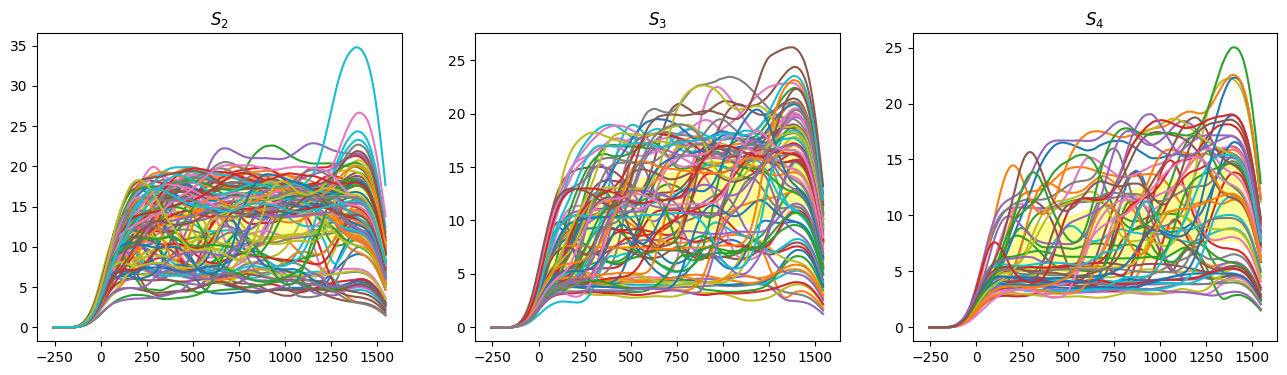

In [18]:
s2_dI_conv_all_1d = []
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
for array in s2_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s2_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s2_dI_conv_all_1d = np.array(s2_dI_conv_all_1d)
s2_dI_mean = np.mean(s2_dI_conv_all_1d, axis=0)
QC_s2_dI_std = np.std(s2_dI_conv_all_1d[:QC_s2_weight], axis=0)
NB_s2_dI_std = np.std(s2_dI_conv_all_1d[QC_s2_weight:], axis=0)
s2_dI_std = np.sqrt((QC_s2_dI_std*QC_s2_weight/(QC_s2_weight + NB_s2_weight))**2 + (NB_s2_dI_std*NB_s2_weight/(QC_s2_weight + NB_s2_weight))**2)
print(s2_dI_std.shape)
plt.fill_between(time_vals, s2_dI_mean-s2_dI_std, s2_dI_mean+s2_dI_std, color='yellow', alpha=0.4)
plt.title(r'$S_{2}$')

s3_dI_conv_all_1d = []
plt.subplot(1,3,2)
for array in s3_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s3_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s3_dI_conv_all_1d = np.array(s3_dI_conv_all_1d)
s3_dI_mean = np.mean(s3_dI_conv_all_1d, axis=0)
QC_s3_dI_std = np.std(s2_dI_conv_all_1d[:QC_s3_weight], axis=0)
NB_s3_dI_std = np.std(s2_dI_conv_all_1d[QC_s3_weight:], axis=0)
s3_dI_std = np.sqrt((QC_s3_dI_std*QC_s3_weight/(QC_s3_weight + NB_s3_weight))**2 + (NB_s3_dI_std*NB_s3_weight/(QC_s3_weight + NB_s3_weight))**2)
plt.fill_between(time_vals, s3_dI_mean-s3_dI_std, s3_dI_mean+s3_dI_std, color='yellow', alpha=0.4)
plt.title(r'$S_{3}$')

s4_dI_conv_all_1d = []
plt.subplot(1,3,3)
for array in s4_conv_all_trajs:
    array = array.T
    line = np.sum(np.abs(array[traj_indices]), axis=0)
    #print(line.shape)
    s4_dI_conv_all_1d.append(line)
    plt.plot(time_vals, line)

s4_dI_conv_all_1d = np.array(s4_dI_conv_all_1d)
s4_dI_mean = np.mean(s4_dI_conv_all_1d, axis=0)
QC_s4_dI_std = np.std(s2_dI_conv_all_1d[:QC_s4_weight], axis=0)
NB_s4_dI_std = np.std(s2_dI_conv_all_1d[QC_s4_weight:], axis=0)
s4_dI_std = np.sqrt((QC_s4_dI_std*QC_s4_weight/(QC_s4_weight + NB_s4_weight))**2 + (NB_s4_dI_std*NB_s4_weight/(QC_s4_weight + NB_s4_weight))**2)
plt.fill_between(time_vals, s4_dI_mean-s4_dI_std, s4_dI_mean+s4_dI_std, color='yellow', alpha=0.4)
plt.title(r'$S_{4}$')
plt.show()
# plt.figure()
# plt.plot(time_vals, QC_s2_dI_conv_all_1d)
# plt.show()

# print(QC_s2_dI_conv.shape)

## Plot CI vs t0

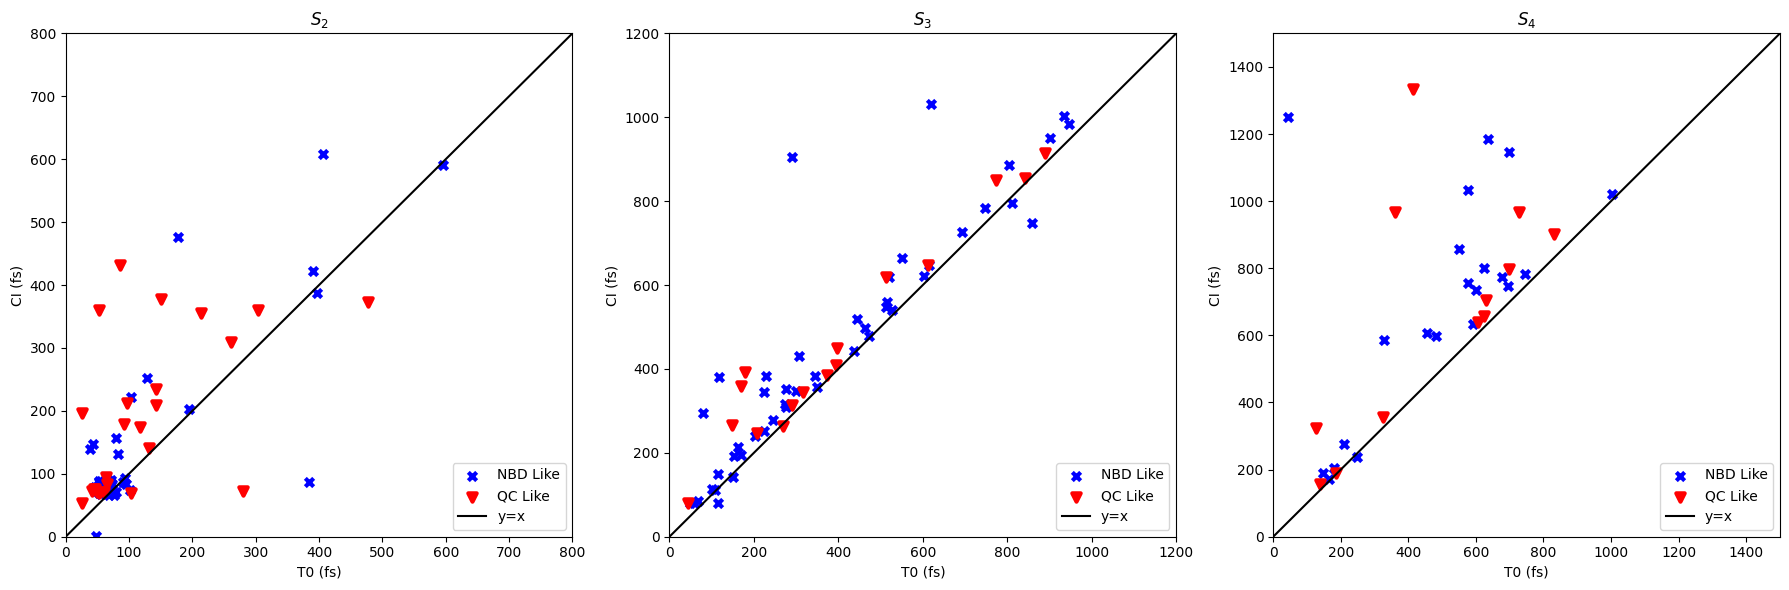

In [19]:
x_vals = np.linspace(0,1500,100)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.scatter(NB_s2_t0s, NB_s2_CIs, color="blue", marker="x", linewidths=3, label="NBD Like")
plt.scatter(QC_s2_t0s, QC_s2_CIs, color="red", marker='v', linewidths=3, label="QC Like")
plt.plot(x_vals, x_vals, color="k", label="y=x")
# plt.axhline(y=NB_s2_CI, color="blue", label="NBD Crossing", linestyle="--")
# plt.axhline(y=QC_s2_CI, color="red", label="QC Crossing", linestyle='--')
plt.xlabel("T0 (fs)")
plt.ylabel("CI (fs)")
plt.title(r'$S_{2}$')
plt.xlim(0,800)
plt.ylim(0,800)
plt.legend(loc="lower right")

plt.subplot(1,3,2)
plt.scatter(NB_s3_t0s, NB_s3_CIs, color="blue", marker="x", linewidths=3, label="NBD Like")
plt.scatter(QC_s3_t0s, QC_s3_CIs, color="red", marker="v", linewidths=3, label="QC Like")
plt.plot(x_vals, x_vals, color="k", label="y=x")
# plt.axhline(y=NB_s3_CI, color="blue", label="NBD Crossing", linestyle="--")
# plt.axhline(y=QC_s3_CI, color="red", label="QC Crossing", linestyle='--')
plt.xlabel("T0 (fs)")
plt.ylabel("CI (fs)")
plt.title(r'$S_{3}$')
plt.xlim(0,1200)
plt.ylim(0,1200)
plt.legend(loc="lower right")

plt.subplot(1,3,3)
plt.scatter(NB_s4_t0s, NB_s4_CIs, color="blue", marker="x", linewidths=3, label="NBD Like")
plt.scatter(QC_s4_t0s, QC_s4_CIs, color="red", marker="v", linewidths=3, label="QC Like")
plt.plot(x_vals, x_vals, color="k", label="y=x")
# plt.axhline(y=NB_s4_CI, color="blue", label="NBD Crossing", linestyle="--")
# plt.axhline(y=QC_s4_CI, color="red", label="QC Crossing", linestyle='--')
plt.xlabel("T0 (fs)")
plt.ylabel("CI (fs)")
plt.title(r'$S_{4}$')
plt.xlim(0,1500)
plt.ylim(0,1500)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Applying Weights to Trajectories
Applying weights to account for contributions of each initial state in terms of number of trajectories in each state

In [20]:
dI_I_all_traj = np.mean((QC_s2_dI, QC_s3_dI, QC_s4_dI, NB_s2_dI, NB_s3_dI, NB_s4_dI), axis=0)
dI_I_weighted_traj_conv = np.sum(((QC_s2_dI_conv*QC_s2_weight), (NB_s2_dI_conv*NB_s2_weight), 
                             (QC_s3_dI_conv*QC_s3_weight), (NB_s3_dI_conv*NB_s3_weight),
                             (QC_s4_dI_conv*QC_s4_weight), (NB_s4_dI_conv*NB_s4_weight)), axis=0)/204
dI_I_weighted_traj = np.sum(((QC_s2_dI*QC_s2_weight), (NB_s2_dI*NB_s2_weight), 
                             (QC_s3_dI*QC_s3_weight), (NB_s3_dI*NB_s3_weight),
                             (QC_s4_dI*QC_s4_weight), (NB_s4_dI*NB_s4_weight)), axis=0)/204
dI_I_all_traj_conv = np.mean((QC_s2_dI_conv, QC_s3_dI_conv, QC_s4_dI_conv, NB_s2_dI_conv, NB_s3_dI_conv, NB_s4_dI_conv), axis=0)
dI_I_all_traj_feat1 = np.sum(np.abs(dI_I_all_traj[traj_indices]), axis=0)
dI_I_all_traj_feat1_conv = np.sum(np.abs(dI_I_all_traj_conv[traj_indices]), axis=0)
print(dI_I_all_traj.shape)
print(dI_I_all_traj_feat1.shape)

fit_NBD = 59.2
fit_QC = 16.9


s2_weighted = np.sum(((QC_s2_dI_conv*QC_s2_weight), (NB_s2_dI_conv*NB_s2_weight)), axis=0)/(QC_s2_weight+NB_s2_weight)
dI_I_s2_feat1 = np.sum(np.abs(s2_weighted[traj_indices]), axis=0)
dI_I_s2_feat1_conv = np.sum(np.abs(s2_weighted[traj_indices]), axis=0)
print(dI_I_s2_feat1.shape)

s2_all = np.mean((NB_s2_dI, QC_s2_dI), axis=0)
s2_all_fitting_weight = np.mean((NB_s2_dI*fit_NBD, QC_s2_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s2_all_conv = np.mean((NB_s2_dI_conv, QC_s2_dI_conv), axis=0)
s2_all_conv_fitting_weight = np.sum((NB_s2_dI_conv*fit_NBD, QC_s2_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s2_fit_feat1 = np.sum(np.abs(s2_all_conv_fitting_weight[traj_indices]), axis=0)

s3_weighted = np.sum(((QC_s3_dI_conv*QC_s3_weight), (NB_s3_dI_conv*NB_s3_weight)), axis=0)/(QC_s3_weight+NB_s3_weight)
dI_I_s3_feat1 = np.sum(np.abs(s3_weighted[traj_indices]), axis=0)
dI_I_s3_feat1_conv = np.sum(np.abs(s3_weighted[traj_indices]), axis=0)
print(dI_I_s3_feat1.shape)

s3_all = np.mean((NB_s3_dI, QC_s3_dI), axis=0)
s3_all_fitting_weight = np.mean((NB_s3_dI*fit_NBD, QC_s3_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s3_all_conv = np.mean((NB_s3_dI_conv, QC_s3_dI_conv), axis=0)
s3_all_conv_fitting_weight = np.sum((NB_s3_dI_conv*fit_NBD, QC_s3_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s3_fit_feat1 = np.sum(np.abs(s3_all_conv_fitting_weight[traj_indices]), axis=0)

s4_weighted = np.sum(((QC_s4_dI_conv*QC_s4_weight), (NB_s4_dI_conv*NB_s4_weight)), axis=0)/(QC_s4_weight+NB_s4_weight)
dI_I_s4_feat1 = np.sum(np.abs(s4_weighted[traj_indices]), axis=0)
dI_I_s4_feat1_conv = np.sum(np.abs(s4_weighted[traj_indices]), axis=0)

s4_all = np.mean((NB_s4_dI, QC_s4_dI), axis=0)
s4_all_fitting_weight = np.mean((NB_s4_dI*fit_NBD, QC_s4_dI*fit_QC), axis=0)/(fit_NBD+fit_QC)
s4_all_conv = np.mean((NB_s4_dI_conv, QC_s4_dI_conv), axis=0)
s4_all_conv_fitting_weight = np.sum((NB_s4_dI_conv*fit_NBD, QC_s4_dI_conv*fit_QC), axis=0)/(fit_NBD+fit_QC)
dI_I_s4_fit_feat1 = np.sum(np.abs(s4_all_conv_fitting_weight[traj_indices]), axis=0)


(500, 2800)
(2800,)
(2800,)
(2800,)


## Plot 2D dI/I for all S4 Trajectories

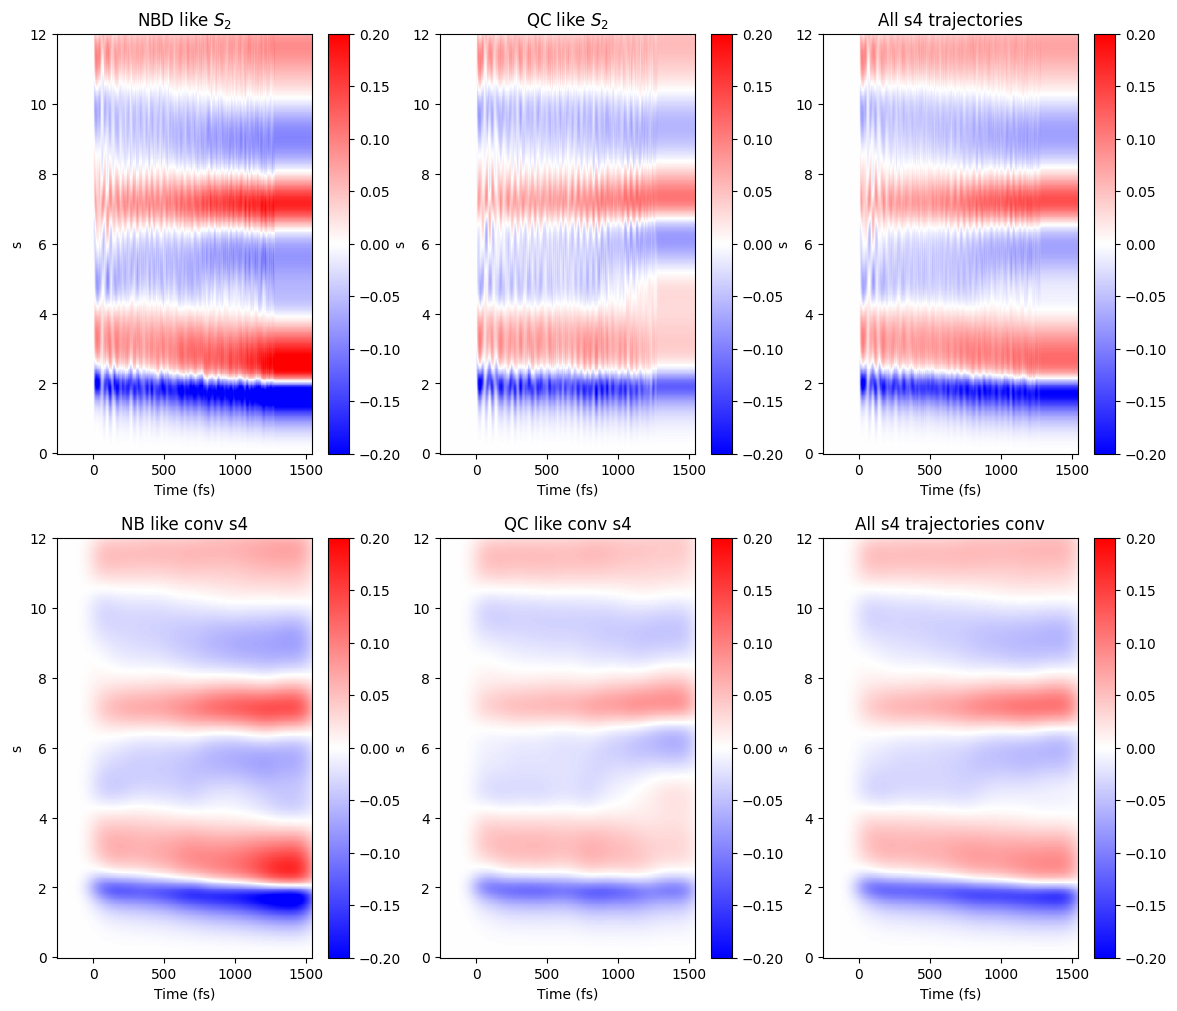

In [22]:
plt.figure(figsize=(14,12))
plt.subplot(2,3,1)
plt.pcolor(time_vals, NB_s2_traj["0107"]["s"], NB_s4_dI, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title(r"NBD like $S_{4}$")

plt.subplot(2,3,2)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], QC_s4_dI, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title(r"QC like $S_{4}$")

s4_all = np.mean((NB_s4_dI, QC_s4_dI), axis=0)
#print(s4_all.shape)
plt.subplot(2,3,3)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], s4_all, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title(r"All $S_{4}$ trajectories")
plt.colorbar()

plt.subplot(2,3,4)
plt.pcolor(time_vals, NB_s2_traj["0107"]["s"], NB_s4_dI_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title(r"NB like conv $S_{4}$")

plt.subplot(2,3,5)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], QC_s4_dI_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.colorbar()
plt.title(r"QC like conv $S_{4}$")

s4_all_conv = np.mean((NB_s4_dI_conv, QC_s4_dI_conv), axis=0)
#print(s4_all.shape)
plt.subplot(2,3,6)
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], s4_all_conv, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title(r"All $S_{4}$ trajectories conv")
plt.colorbar()
plt.show()

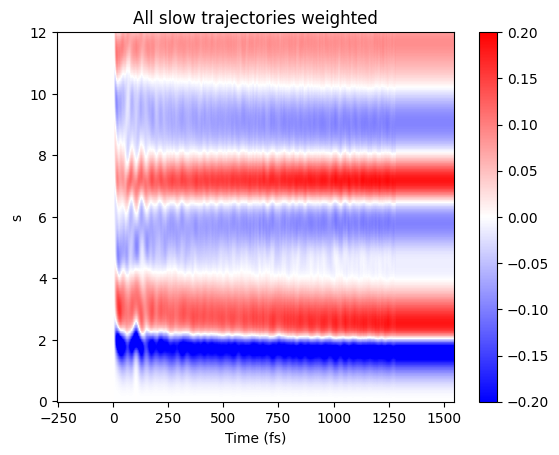

In [23]:
plt.figure()
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], dI_I_weighted_traj, cmap='bwr')
plt.clim(-0.2, 0.2)
plt.xlabel("Time (fs)")
plt.ylabel("s")
plt.title("All slow trajectories weighted")
plt.colorbar()
plt.show()

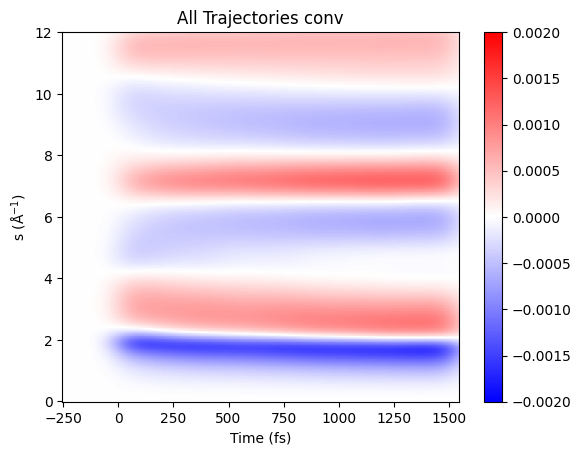

In [24]:
plt.figure()
plt.pcolor(time_vals, QC_s2_traj["0014"]["s"], dI_I_all_traj_conv/100, cmap='bwr')
plt.clim(-0.002, 0.002)
plt.xlabel("Time (fs)")
plt.ylabel("s ($\mathrm{\AA}^{-1}$)")
plt.title("All Trajectories conv")
plt.colorbar()
plt.show()

## Plotting Experimental Data

C:\Users\laure\AppData\Local\Temp\ipykernel_26948\1871513724.py:5: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\laure\AppData\Local\Temp\ipykernel_26948\1871513724.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


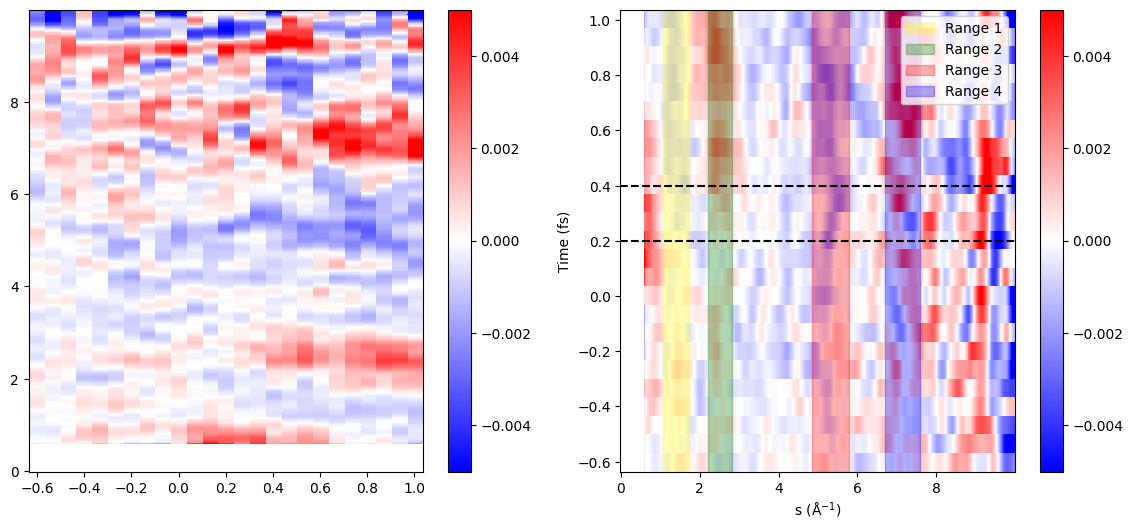

In [25]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.pcolor(time_exp, s_simu, dI_I_smooth, cmap='bwr')
plt.clim(-0.005,0.005)
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(s_simu, time_exp, dI_I_smooth.T, cmap='bwr')
plt.clim(-0.005, 0.005)
plt.xlabel(f"s {inv_angs}")
plt.colorbar()
plt.ylabel("Time (fs)")

# Overlay the shaded regions for each range
plt.axvspan(min_s1, max_s1, color='yellow', alpha=0.3, label='Range 1')  # shade range 1
plt.axvspan(min_s2, max_s2, color='green', alpha=0.3, label='Range 2')  # shade range 2
plt.axvspan(min_s3, max_s3, color='red', alpha=0.3, label='Range 3')    # shade range 3
plt.axvspan(min_s4, max_s4, color='blue', alpha=0.3, label='Range 4')   # shade range 4
plt.axhline(y=0.2, color='k', linestyle='--')
plt.axhline(y=0.4, color='k',  linestyle='--')

# Add a legend
plt.legend(loc='upper right')

plt.show()

## Plot Time Lineouts

In [26]:
def normalize(data_set, max_val='Auto', min_val='Auto'):
    if max_val == 'Auto':
        normalized_data = (data_set - np.nanmin(data_set))/(np.nanmax(data_set) - np.nanmin(data_set))
        std_factor = 1/(np.nanmax(data_set) - np.nanmin(data_set))
    elif isinstance(max_val, float) and isinstance(min_val, float):
        normalized_data = (data_set - min_val)/(max_val - min_val)
        std_factor = 1/(max_val-min_val)
    return normalized_data, std_factor

In [27]:
#print(dI_I_boot.shape)
dI_I_ave = np.nanmean(dI_I_boot, axis=2).T
#print(dI_I_ave)
dI_I_feat1 = np.nansum(np.abs(dI_I_boot[exp_indices][:]), axis=0)
#print(dI_I_feat1.shape)
dI_I_feat1_mean = np.nanmean(dI_I_feat1[:-4], axis=1)
dI_I_feat1_err = np.nanstd(dI_I_feat1[:-4], axis=1)
#print(dI_I_feat1_err)

min_val = np.nanmean(dI_I_feat1_mean[np.where((time_exp > -0.3) & (time_exp < 0.0))[0]])
max_val = np.nanmean(dI_I_feat1_mean[np.where((time_exp > 0.8) & (time_exp < 1.00))[0]])

#print(min_val, max_val)
dI_I_feat1_norm, std_factor = normalize(dI_I_feat1_mean, max_val=max_val, min_val=min_val)
dI_I_feat1_err_norm = dI_I_feat1_err*std_factor
#print(dI_I_feat1_norm)

electronic_idx = np.where((s_simu > 0.6) & (s_simu < 1.1))[0]
dI_I_electronic = np.nansum(np.abs(dI_I_boot[electronic_idx][:]), axis=0)
dI_I_elec_mean = np.nanmean(dI_I_electronic[:-4], axis=1)
dI_I_elec_err = np.nanstd(dI_I_electronic[:-4], axis=1)

e_min = np.nanmean(dI_I_elec_mean[np.where((time_exp > -0.3) & (time_exp < 0.0))[0]])
e_max = np.nanmean(dI_I_elec_mean[np.where((time_exp > 0.1) & (time_exp < 0.3))[0]])
dI_I_elec_norm, std_factor = normalize(dI_I_elec_mean, max_val=e_max, min_val=e_min)
dI_I_elec_err_norm = dI_I_elec_err*std_factor

#print(time_new.shape)

## Gaussian and erf Fit for Lineouts

### Electronic Feature

Optimized parameters: 
 a1 = 1.0904  
 sigma = 56.15 
 FWHM = 1.32e+02       
 tau = 174.39 
 t0 = -0.00 
 offset = -0.04


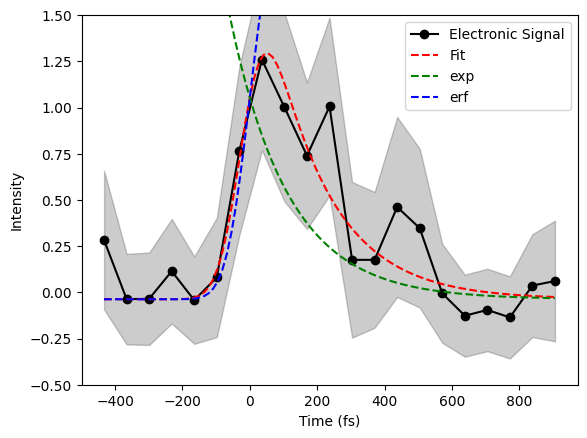

In [29]:


# Define the function I(t, tau) based on the equation
def model(t, a, sigma, tau, c):
    term1 = (sigma / (2 * tau)) - (t - c) / sigma
    term2 = ((sigma / (2 * tau)) ** 2) - (t - c) / tau
    return a * (1 - erf(term1)) * np.exp(term2)

def model_test(t, a, sigma, tau2, c, b):
    term1 = -(t - c) / sigma
    term2 =  -(t - c) / tau2
    return a * erf(term1)* np.exp(term2) + b

def model_2(t, a, sigma, tau, c):
    term1 = (t - c) / sigma
    term2 =  -(t - c) / tau
    return a * (erf(term1)) * np.exp(term2)

def erf_function(t, sigma, c):
    fit = (1-erf(-(t-c)/(np.sqrt(2)*sigma)))
    return fit

def exp_function(t, tau2, c):
    fit = np.exp(-(t-c)/tau2)
    return fit

def fit_model(t, a, sigma, tau2, c, b):
    combined_fit = a* (erf_function(t, sigma, c)) * (exp_function(t, tau2, c)) + b
    return combined_fit

# Generate synthetic data (adjust parameters as needed)
t_exp = time_new*1000
y_exp = dI_I_elec_norm

# Initial guesses for the fit parameters
p0 = [1.5, 50, 60, 100, 0]  # a, sigma, tau, center, offset
bounds = ([0, 0, 0, -50], [5, 100, 500, 150])

# Fit the data using curve_fit
popt_exp, pcov_exp = curve_fit(fit_model, t_exp[:], y_exp[:], sigma=dI_I_elec_err_norm, p0=p0)


# Print the optimized parameters 
print(f"Optimized parameters: \n a1 = {popt_exp[0]:.4f}  \n sigma = {popt_exp[1]:.2f} \n FWHM = {2.355*popt_exp[1]:.3} \
      \n tau = {popt_exp[2]:.2f} \n t0 = {popt_exp[3]:.2f} \n offset = {popt_exp[4]:.2f}")
x_new = np.linspace(np.min(t_exp), np.max(t_exp), 100)
fit_line =  fit_model(x_new, *popt_exp)
exp_line = popt_exp[0] * exp_function(x_new, popt_exp[2], popt_exp[3]) + popt_exp[4]
erf_line = popt_exp[0] * erf_function(x_new, popt_exp[1], popt_exp[3]) + popt_exp[4]
test = erf((x_new))
test2 = np.exp(-(x_new-200)/1000)


plt.figure()
plt.plot(t_exp, y_exp, "-o", color="k", label="Electronic Signal")
plt.fill_between(t_exp, y_exp-dI_I_elec_err_norm, y_exp+dI_I_elec_err_norm, color='k', alpha=0.2)
plt.plot(x_new, fit_line, "--", label="Fit", color="red")
plt.plot(x_new, exp_line, "--", color="green", label="exp")
plt.plot(x_new, erf_line, "--", color="blue", label="erf")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.legend()
plt.ylim(-0.5, 1.5)
plt.show()

### Structural Features

Optimized parameters: 
 a = 0.5542 
 sigma = 196.61 
 FWHM = 4.63e+02       
 t0 = 382.90 
 offset = -0.02


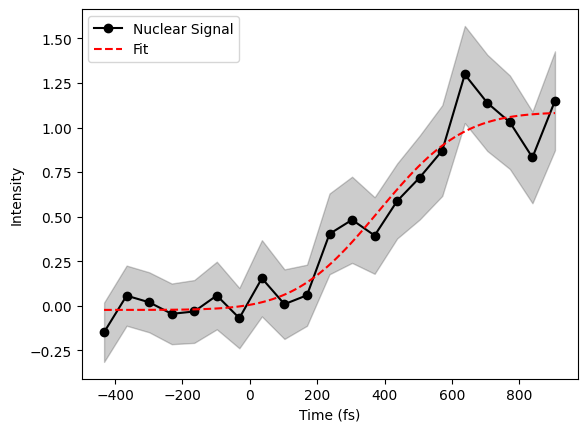

In [30]:
def erf_function(t, a, sigma, c, b):
    fit = a* (1-erf(-(t-c)/((np.sqrt(2)*sigma)))) + b
    return fit

# Generate synthetic data (adjust parameters as needed)
t_exp = time_new*1000
y_exp = dI_I_feat1_norm

# Initial guesses for the fit parameters
p0 = [1.0, 150, 500, 0] # a, sigma, tau, c
bounds = ([0, 0, 0, -0.01], [1.5, 100, 300, 0])

# Fit the data using curve_fit
popt_exp, pcov_exp = curve_fit(erf_function, t_exp, y_exp, sigma=dI_I_feat1_err_norm, p0=p0)

# Print the optimized parameters
print(f"Optimized parameters: \n a = {popt_exp[0]:.4f} \n sigma = {popt_exp[1]:.2f} \n FWHM = {2.355*popt_exp[1]:.3} \
      \n t0 = {popt_exp[2]:.2f} \n offset = {popt_exp[3]:.2f}")
x_new = np.linspace(np.min(t_exp), np.max(t_exp), 100)
nuc_fit_line =  erf_function(x_new, *popt_exp)
# exp_line = popt_exp[0] * exp_function(x_new, popt_exp[3], popt_exp[4])
# erf_line = popt_exp[0] * erf_function(x_new, popt_exp[1], popt_exp[2], popt_exp[4])
# Plot the data and the fit
# plt.subplot(1,2,1)
# plt.scatter(t_data, y_data, label="Data", s=10)
# plt.plot(t_data, model(t_data, *popt), label="Fit", color="red")
# plt.legend()
plt.figure()
plt.plot(t_exp, y_exp, "-o", color="k", label="Nuclear Signal")
plt.fill_between(t_exp, y_exp-dI_I_feat1_err_norm, y_exp+dI_I_feat1_err_norm, color='k', alpha=0.2)
plt.plot(x_new, nuc_fit_line, '--', label="Fit", color="red")
# plt.plot(x_new, exp_line, "--", color="green")
# plt.plot(x_new, erf_line, "--", color="blue")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.legend()
plt.show()


### Both Together

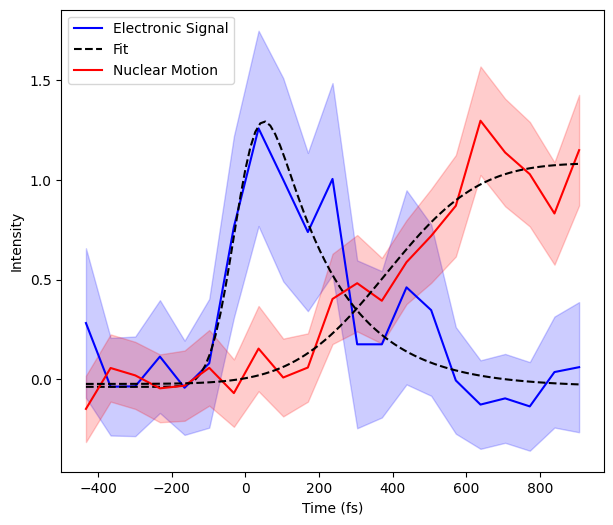

In [31]:
# plt.figure(figsize=(6, 6))
# # plt.subplot(1,2,1)
# plt.plot(time_new*1000, dI_I_elec_mean, color="blue", label="Electronic Feature")
# plt.fill_between(time_new*1000, dI_I_elec_mean-dI_I_elec_err, dI_I_elec_mean+dI_I_elec_err, color='blue', alpha=0.2)
# plt.plot(time_new*1000, dI_I_feat1_mean, color="red", label="Other Features")
# plt.fill_between(time_new*1000, dI_I_feat1_mean-dI_I_feat1_err, dI_I_feat1_mean+dI_I_feat1_err, color='red', alpha=0.2)
# plt.legend()
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.show()

# plt.subplot(1,2,2)
plt.figure(figsize=(7,6))
plt.plot(time_new*1000, dI_I_elec_norm, color="blue", label="Electronic Signal")
plt.fill_between(time_new*1000, dI_I_elec_norm-dI_I_elec_err_norm, dI_I_elec_norm+dI_I_elec_err_norm, color='blue', alpha=0.2)
plt.plot(x_new, fit_line, "--", color='k', label="Fit")
plt.plot(time_new*1000, dI_I_feat1_norm, color="red", label="Nuclear Motion")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='red', alpha=0.2)
plt.plot(x_new, nuc_fit_line, "--", color='k')
plt.legend()
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.show()

## Experimental Data vs Trajectory Lineouts

In [32]:
NB_s2_min = np.nanmean(NB_s2_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s2_max = np.nanmean(NB_s2_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
NB_s2_feat1_norm, NB_s2_err_factor = normalize(NB_s2_feat_1_conv, max_val=NB_s2_max, min_val=NB_s2_min)
print(NB_s2_feat1_norm.shape)
QC_s2_min = np.nanmean(QC_s2_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s2_max = np.nanmean(QC_s2_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
QC_s2_feat1_norm, QC_s2_err_factor = normalize(QC_s2_feat_1_conv, max_val=QC_s2_max, min_val=QC_s2_min)
print(QC_s2_feat1_norm.shape)

s2_weighted_min = np.nanmean(dI_I_s2_feat1_conv[np.where((time_vals < -100))[0]])
s2_weighted_max = np.nanmean(dI_I_s2_feat1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s2_norm, dI_I_s2_err_factor = normalize(dI_I_s2_feat1_conv, max_val=s2_weighted_max, min_val=s2_weighted_min)
dI_I_s2_norm_err = s2_dI_std*dI_I_s2_err_factor
s2_fit_min = np.nanmean(dI_I_s2_fit_feat1[np.where((time_vals < -100))[0]])
s2_fit_max = np.nanmean(dI_I_s2_fit_feat1[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s2_fit_norm, _ = normalize(dI_I_s2_fit_feat1, max_val=s2_fit_max, min_val=s2_fit_min)

NB_s3_min = np.nanmean(NB_s3_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s3_max = np.nanmean(NB_s3_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
NB_s3_feat1_norm, NB_s3_err_factor = normalize(NB_s3_feat_1_conv, max_val=NB_s3_max, min_val=NB_s3_min)
print(NB_s3_feat1_norm.shape)

QC_s3_min = np.nanmean(QC_s3_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s3_max = np.nanmean(QC_s3_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
QC_s3_feat1_norm, QC_s3_err_factor = normalize(QC_s3_feat_1_conv, max_val=QC_s3_max, min_val=QC_s3_min)

s3_weighted_min = np.nanmean(dI_I_s3_feat1_conv[np.where((time_vals < -100))[0]])
s3_weighted_max = np.nanmean(dI_I_s3_feat1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s3_norm, dI_I_s3_err_factor = normalize(dI_I_s3_feat1_conv, max_val=s3_weighted_max, min_val=s3_weighted_min)
dI_I_s3_norm_err = s3_dI_std*dI_I_s3_err_factor
s3_fit_min = np.nanmean(dI_I_s3_fit_feat1[np.where((time_vals < -100))[0]])
s3_fit_max = np.nanmean(dI_I_s3_fit_feat1[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s3_fit_norm, _ = normalize(dI_I_s3_fit_feat1, max_val=s3_fit_max, min_val=s3_fit_min)

NB_s4_min = np.nanmean(NB_s4_feat_1_conv[np.where((time_vals < -100))[0]])
NB_s4_max = np.nanmean(NB_s4_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
NB_s4_feat1_norm, NB_s4_err_factor = normalize(NB_s4_feat_1_conv, max_val=NB_s4_max, min_val=NB_s4_min)
print(NB_s4_feat1_norm.shape)

QC_s4_min = np.nanmean(QC_s4_feat_1_conv[np.where((time_vals < -100))[0]])
QC_s4_max = np.nanmean(QC_s4_feat_1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
QC_s4_feat1_norm, QC_s4_err_factor = normalize(QC_s4_feat_1_conv, max_val=QC_s4_max, min_val=QC_s4_min)

s4_weighted_min = np.nanmean(dI_I_s4_feat1_conv[np.where((time_vals < -100))[0]])
s4_weighted_max = np.nanmean(dI_I_s4_feat1_conv[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s4_norm, dI_I_s4_err_factor = normalize(dI_I_s4_feat1_conv, max_val=s4_weighted_max, min_val=s4_weighted_min)
dI_I_s4_norm_err = s4_dI_std*dI_I_s4_err_factor
s4_fit_min = np.nanmean(dI_I_s4_fit_feat1[np.where((time_vals < -100))[0]])
s4_fit_max = np.nanmean(dI_I_s4_fit_feat1[np.where((time_vals > 800) & (time_vals < 1000))[0]])
dI_I_s4_fit_norm, _ = normalize(dI_I_s4_fit_feat1, max_val=s4_fit_max, min_val=s4_fit_min)

(2800,)
(2800,)
(2800,)
(2800,)


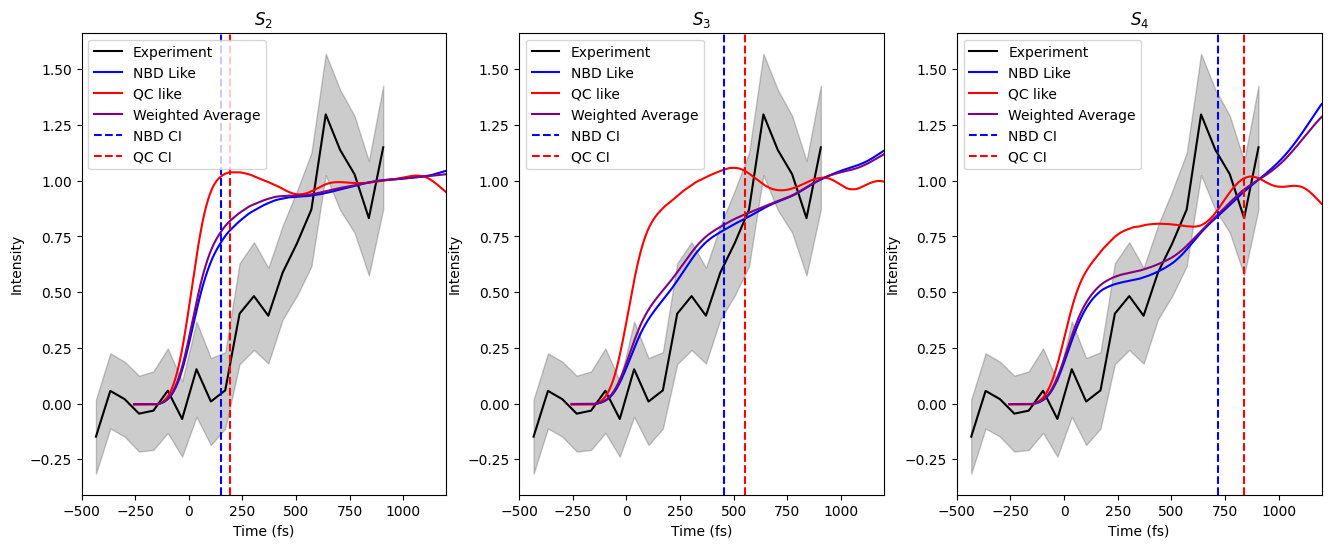

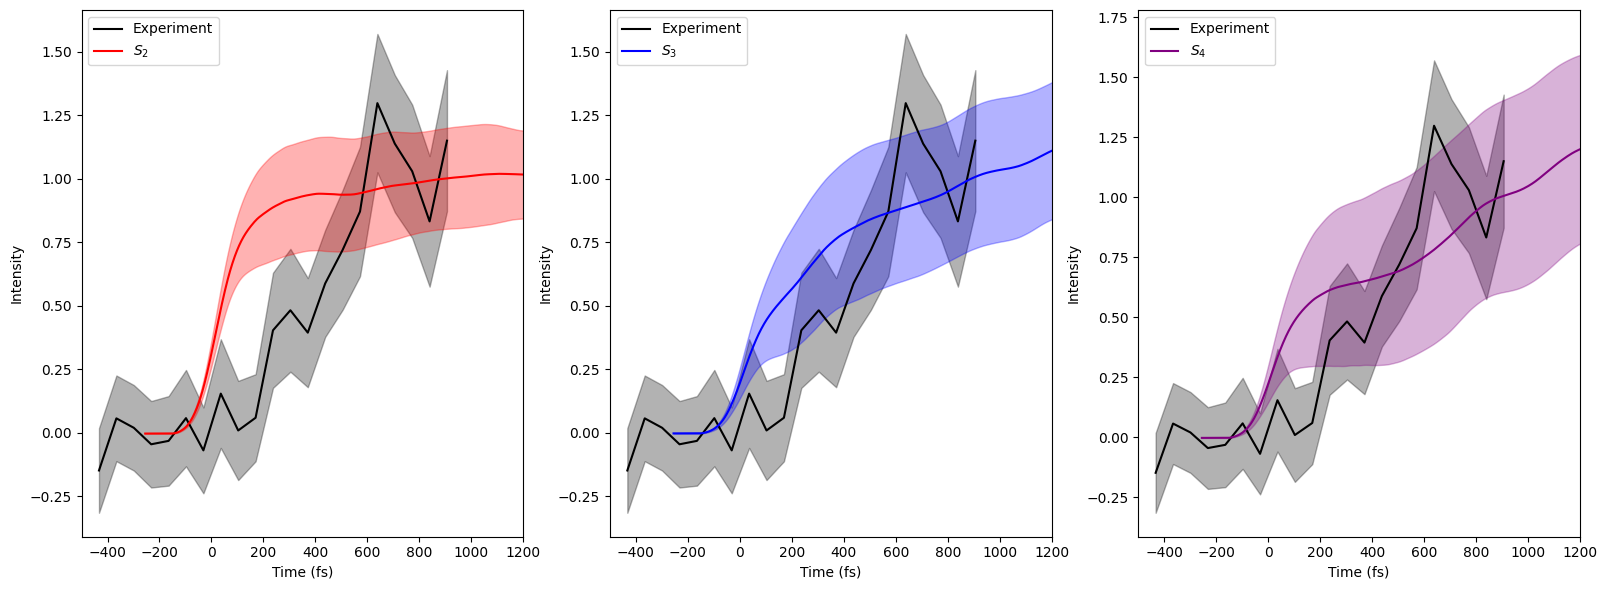

In [33]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*100, yerr=dI_I_electronic_err*100, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s2_feat1_norm,  color="blue", label="NBD Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s2_feat1_norm, color="red", label="QC like")
plt.plot(time_vals, dI_I_s2_fit_norm, color="purple", label="Weighted Average")
#plt.plot(time_vals, QC_s2_feat_1_conv, color="red", label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.axvline(x=NB_s2_CI, color="blue", label="NBD CI", linestyle="--")
plt.axvline(x=QC_s2_CI, color="red", label="QC CI", linestyle="--")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title(r'$S_{2}$')
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,2)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*50, yerr=dI_I_electronic_err*50, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s3_feat1_norm,  color="blue", label="NBD Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s3_feat1_norm, color="red", label="QC like")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.plot(time_vals, dI_I_s3_fit_norm, color="purple", label="Weighted Average")
plt.axvline(x=NB_s3_CI, color="blue", label="NBD CI", linestyle="--")
plt.axvline(x=QC_s3_CI, color="red", label="QC CI", linestyle="--")
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title(r'$S_{3}$')
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,3)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
#plt.errorbar(time_exp*1000, dI_I_electronic*50, yerr=dI_I_electronic_err*50, color="orange", label="Electronic Feature")
plt.plot(time_vals, NB_s4_feat1_norm,  color="blue", label="NBD Like")
#plt.plot(time_vals, NB_s2_feat_1_conv,  color="blue", label="NB Like")
plt.plot(time_vals, QC_s4_feat1_norm, color="red", label="QC like")
plt.plot(time_vals, dI_I_s4_fit_norm, color="purple", label="Weighted Average")
#plt.plot(time_vals, (NB_s4_feat_1 + QC_s4_feat_1), label="Sum")
plt.axvline(x=NB_s4_CI, color="blue", label="NBD CI", linestyle="--")
plt.axvline(x=QC_s4_CI, color="red", label="QC CI", linestyle='--')
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.title(r'$S_{4}$')
plt.xlim(-500, 1200)
plt.legend()

plt.show()

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.3)
plt.plot(time_vals, dI_I_s2_norm,  color="red", label=r'$S_{2}$')
plt.fill_between(time_vals, dI_I_s2_norm-dI_I_s2_norm_err, dI_I_s2_norm+dI_I_s2_norm_err, color='red', alpha=0.3)
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,2)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.3)
plt.plot(time_vals, dI_I_s3_norm, color="blue", label=r'$S_{3}$')
plt.fill_between(time_vals, dI_I_s3_norm-dI_I_s3_norm_err, dI_I_s3_norm+dI_I_s3_norm_err, color='blue', alpha=0.3)
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.xlim(-500, 1200)
plt.legend()

plt.subplot(1,3,3)
plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.3)
plt.plot(time_vals, dI_I_s4_norm, color='purple', label=r'$S_{4}$')
plt.fill_between(time_vals, dI_I_s4_norm-dI_I_s4_norm_err, dI_I_s4_norm+dI_I_s4_norm_err, color='purple', alpha=0.3)
plt.xlabel("Time (fs)")
plt.ylabel("Intensity")
plt.xlim(-500, 1200)
plt.legend()

plt.tight_layout()
plt.show()

# plt.subplot(1,2,2)
# plt.plot(time_new*1000, dI_I_feat1_norm, color="k", label="Experiment")
# plt.fill_between(time_new*1000, dI_I_feat1_norm-dI_I_feat1_err_norm, dI_I_feat1_norm+dI_I_feat1_err_norm, color='k', alpha=0.2)
# plt.plot(time_vals, dI_I_s2_fit_norm,  color="blue", label=r'$S_{2}$')
# plt.plot(time_vals, dI_I_s3_fit_norm, color="red", label=r'$S_{3}$')
# plt.plot(time_vals, dI_I_s4_fit_norm, color='purple', label=r'$S_{4}$')
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.xlim(-500, 1200)
# plt.legend()
# plt.title("Fitting Weighted")
# plt.show()


## Electronic Feature vs Ab-Initio Calculations

(412,)


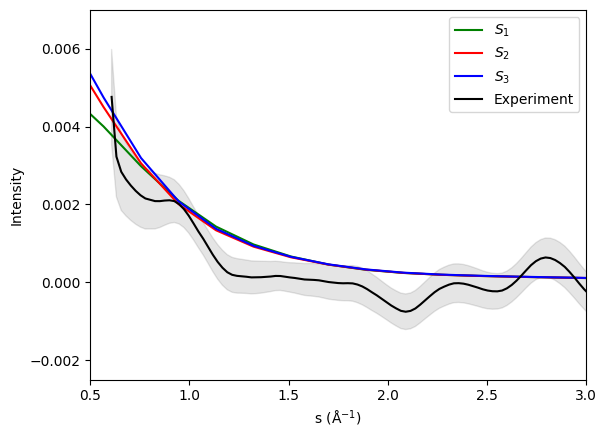

In [34]:
early_data = np.array(np.nanmean(dI_I_boot[:, np.where((time_exp > 0.0)& (time_exp <= 0.2))[0], :], axis=1))
early_data_std = np.nanstd(early_data, axis=1)
early_data = np.mean(early_data, axis=1)
print(early_data.shape)

plt.figure()
plt.plot(e_scat_s, s1_e_scattering/200, color="green", label=r'$S_{1}$')
plt.plot(e_scat_s, s2_e_scattering/200, color="red", label=r'$S_{2}$')
plt.plot(e_scat_s, s3_e_scattering/200, color="blue", label=r'$S_{3}$')
plt.plot(s_simu, early_data, color='k', label="Experiment")
plt.fill_between(s_simu, early_data-early_data_std, early_data+early_data_std, color='k', alpha=0.1)
plt.xlim(0.5,3)
plt.ylim(-0.0025, 0.007)
plt.legend()
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.show()

## Get Product Ratios

In [34]:
s_temp, frag_dI_new = np.loadtxt("frags.txt", skiprows=1, unpack=True)
_, QC_dI_hot = np.loadtxt("QC.txt", skiprows=1, unpack=True)
_, NB_dI_hot = np.loadtxt("NB.txt", skiprows=1, unpack=True)

(500,)
(500,)


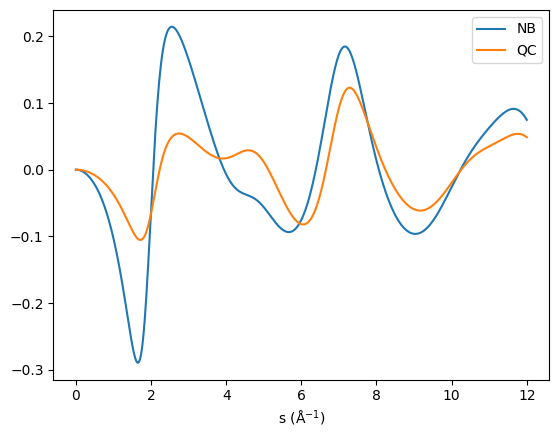

In [35]:
NB_late_all = np.array((NB_s2_late, NB_s3_late, NB_s4_late))
NB_traj_late_times = np.mean(NB_late_all, axis=0)
print(NB_traj_late_times.shape)

QC_late_all = np.array((QC_s2_late, QC_s3_late, QC_s4_late))
QC_traj_late_times = np.mean(QC_late_all, axis=0)
print(QC_traj_late_times.shape)

plt.figure()
plt.plot(traj_s, NB_traj_late_times, label="NB")
plt.plot(traj_s, QC_traj_late_times, label="QC")
#plt.plot(e_scat_s, e_scattering_mean)
plt.legend()
plt.xlabel(f"s {inv_angs}")
plt.show()

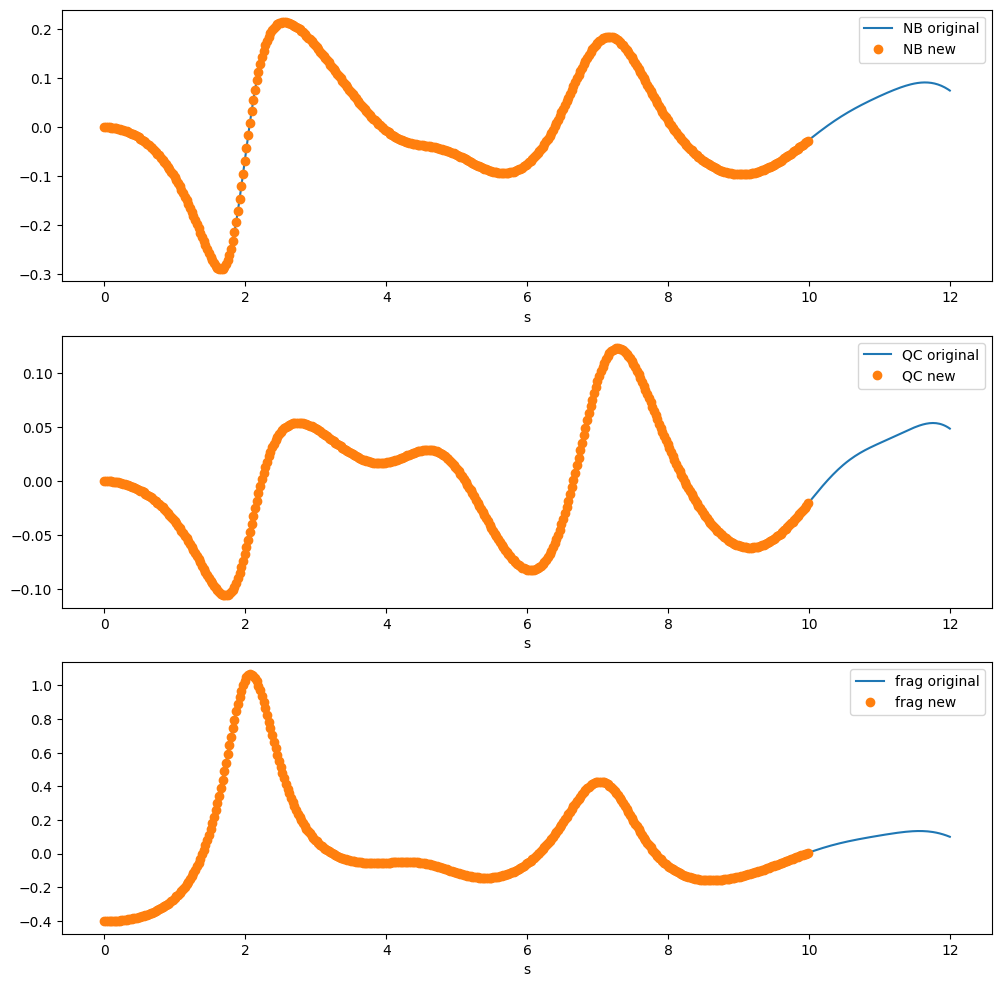

In [36]:
from scipy.interpolate import interp1d


# Original non-linear array (sine wave with 50 points)
NB_late_new = NB_traj_late_times
QC_late_new = QC_traj_late_times
# e_scat_sig = e_scattering_mean

# NB_late_new = NB_dI_hot
# QC_late_new = QC_dI_hot

# Target array length (we want 100 points in the resampled array)
array2_length = len(s_simu)

# Create an interpolation function for array1 based on its index
x_original = s_temp # Normalized indices for array1
NB_interp_func = interp1d(x_original, NB_late_new, kind='cubic')  # Cubic interpolation
QC_interp_func = interp1d(x_original, QC_late_new, kind='cubic')
frag_interp_func = interp1d(x_original, frag_dI_new, kind='cubic')
# e_interp_func = interp1d(e_scat_s, e_scattering_mean, kind='cubic', bounds_error=False, fill_value="extrapolate")
# Interpolate array1 to match the length of array2
x_target = s_simu # Normalized indices for target length
QC_late_resampled = QC_interp_func(x_target)
NB_late_resampled = NB_interp_func(x_target)
frags_late_resampled = frag_interp_func(x_target)
# e_scat_sig_resampled = e_interp_func(x_target)

# Plot the original and resampled arrays
plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(s_temp, NB_late_new, "-", label="NB original")
plt.plot(s_simu, NB_late_resampled, "o", label="NB new")
plt.xlabel("s")
plt.legend()


plt.subplot(3,1,2)
plt.plot(s_temp, QC_late_new, "-", label="QC original")
plt.plot(s_simu, QC_late_resampled, "o", label="QC new")
plt.xlabel("s")
plt.legend()

plt.subplot(3,1,3)
plt.plot(s_temp, frag_dI_new, "-", label="frag original")
plt.plot(s_simu, frags_late_resampled, "o", label="frag new")
plt.xlabel("s")
plt.legend()

# plt.subplot(4,1,4)
# plt.plot(e_scat_s, e_scat_sig, "-", label="electronic original")
# plt.plot(s_simu, e_scat_sig_resampled, "o", label="electronic new")
# plt.xlabel("s")
# plt.legend()

plt.show()


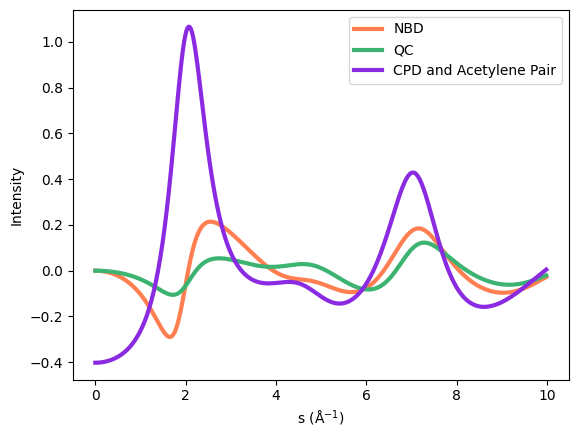

In [37]:
plt.figure()
plt.plot(s_simu, NB_late_resampled, color="coral", linewidth=3, label="NBD")
plt.plot(s_simu, QC_late_resampled, color="mediumseagreen", linewidth=3, label="QC")
# plt.plot(s_simu, frag_simu, label="Fragments Hot")
plt.plot(s_simu, frags_late_resampled, color="blueviolet", linewidth=3, label="CPD and Acetylene Pair")
# plt.plot(s_simu, frag_alt, label="Fragments other?")
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.legend()
plt.show()

In [ ]:
from scipy.io import savemat

NB_late_dict = {"NB_late_line": NB_late_resampled}
QC_late_dict = {"QC_late_line": QC_late_resampled}

savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\NB_late.mat", NB_late_dict)
savemat("C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\QC data and code\\QC_late.mat", QC_late_dict)

## Fitting Average of Bootstrap

In [44]:
def zero_correction(x_data, y_data, theory_data):
    zero_crossings = np.where(np.diff(np.sign(theory_data)))[0]
    
    if zero_crossings.size == 0:  # No zero crossings found
        #print("Warning: No zero crossings found. Returning uncorrected data.")
        return np.zeros_like(x_data), y_data  # No baseline correction
    # for zero in zero_crossings:
    #     print(y_data[zero+10]+y_data[zero-10])
    # Proceed with zero-crossing-based correction
    #print(f"Found zeros at {x_data[zero_crossings]}")
    coeffs = np.polyfit(x_data[zero_crossings], y_data[zero_crossings], 2)
    baseline = np.polyval(coeffs, x_data)
    fixed_data = y_data - baseline
    return baseline, fixed_data


In [45]:
s_min = 0.6
s_max = 9.5
s_idx = np.where((s_simu > s_min) & (s_simu < s_max))[0]

def model(x, a, b, c):
    fit_result = a*(QC_late_resampled[s_idx]) + b*(NB_late_resampled[s_idx]) + c*(frags_late_resampled[s_idx])

    return fit_result

def cost_func(params):
    return np.sum((ave_data-model(x_data, *params))**2)

def zero_fit_cost_func(params, x_data, y_data, std_data):
    theory_line = model(x_data, *params)
    _, corrected_data = zero_correction(x_data, y_data, theory_line)
    residuals = corrected_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

def weighted_cost_func(params, x_data, y_data, std_data):
    residuals = y_data - model(x_data, *params)
    weighted_residuals = residuals / std_data  # Divide residuals by uncertainties
    return np.sum(weighted_residuals**2)

x_data = s_simu[s_idx]
print(dI_I_boot.shape)

late_data = np.array(np.nanmean(dI_I_boot[:, 0:6, :], axis=1))
late_data_std = np.nanstd(late_data, axis=1)
late_data_std = late_data_std[s_idx]
print(f"shape of std of late data matrix {late_data_std.shape}")
y_data = np.nanmean(late_data, axis=1)[s_idx]
ave_data = np.nanmean(late_data, axis=1)[s_idx]
print(ave_data.shape)
print(y_data.shape)
print(x_data.shape)

# Gradient Based Curve Fit
bounds = ([0, 0, 0], [0.1, 0.1, 0.1])
#Fit the data using curve_fit
popt, pcov = curve_fit(model, x_data, ave_data, sigma=late_data_std, bounds=bounds)

print(f"curve fit found values of a, b, c = {popt}")

perc_QC = (popt[0]/sum(popt))*100
perc_NB = (popt[1]/sum(popt))*100
perc_frags = (popt[2]/sum(popt))*100

perc_fit_line = model(x_data, *popt)


rmse = np.sqrt(np.nanmean(ave_data-perc_fit_line)**2)
print("Results from Basic Curve Fit \n")
print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n")

# Simulated Annealing 

print("Results from Dual Annealing \n")
bounds = [(0,0.1), (0,0.1), (0,0.1)]
result = dual_annealing(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std), no_local_search=True)
sa_params = result.x
print(f"dual annealing found results of a, b, c = {sa_params}")
print(result)

perc_QC = (popt[0]/sum(popt))*100
perc_NB = (popt[1]/sum(popt))*100
perc_frags = (popt[2]/sum(popt))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n")

# PSO
print("Results from Differential Evolution \n")
bounds = [(0,0.1), (0,0.1), (0,0.1)]
result = differential_evolution(weighted_cost_func, bounds=bounds, args=(x_data, ave_data, late_data_std))
sa_params = result.x
print(f"differential evolution found results of a, b, c d= {sa_params}")
print(result)

perc_QC = (popt[0]/sum(popt))*100
perc_NB = (popt[1]/sum(popt))*100
perc_frags = (popt[2]/sum(popt))*100

perc_fit_line = model(x_data, *sa_params)

_, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)

rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)

print(f"RMSE = {rmse}")
# Print the optimal parameters
print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags}")

(412, 25, 100)
shape of std of late data matrix (366,)
(366,)
(366,)
(366,)
curve fit found values of a, b, c = [0.00604625 0.00238753 0.00229216]
Results from Basic Curve Fit 

RMSE = 7.139730349788892e-05
 percent QC = 56.37034203359982 
 percent NBD = 22.259418514062144 
 percent fragments = 21.370239452338037 

Results from Dual Annealing 

dual annealing found results of a, b, c = [0.00360548 0.00330779 0.00219321]
 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 927.649013574506
       x: [ 3.605e-03  3.308e-03  2.193e-03]
     nit: 1000
    nfev: 6001
    njev: 0
    nhev: 0
RMSE = 0.0003906315218266556
 percent QC = 56.37034203359982 
 percent NBD = 22.259418514062144 
 percent fragments = 21.370239452338037 

Results from Differential Evolution 

differential evolution found results of a, b, c d= [0.00604623 0.00238753 0.00229215]
             message: Optimization terminated successfully.
             success: True
                 fun: 9

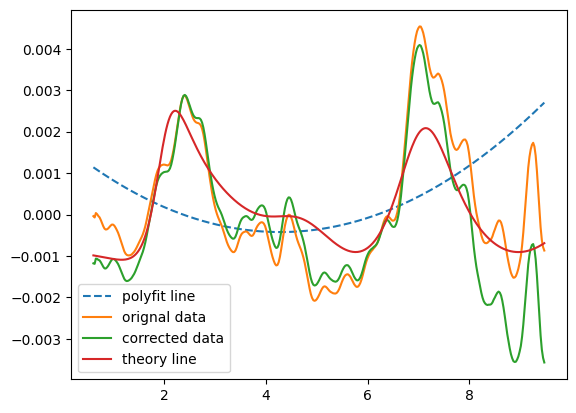

In [46]:
baseline, new_data = zero_correction(x_data, ave_data, perc_fit_line)

plt.figure()
plt.plot(x_data, baseline, "--", label="polyfit line")
plt.plot(x_data, ave_data, label="orignal data")
plt.plot(x_data, new_data, label="corrected data")
plt.plot(x_data, perc_fit_line, label="theory line")
plt.legend()
plt.show()

## Fitting Each Time Step

In [40]:
time_exp

array([ 1.00429653,  0.9373434 ,  0.87039033,  0.80343727,  0.73648413,
        0.66953107,  0.60257793,  0.5356248 ,  0.46867173,  0.4017186 ,
        0.33476553,  0.26781247,  0.20085933,  0.13390627,  0.06695313,
       -0.        , -0.06695307, -0.1339062 , -0.20085927, -0.26781233,
       -0.33476547, -0.40171853, -0.46867167, -0.53562473, -0.60257787])

In [51]:
# Initialize dictionaries to store averages and standard deviations
keys = ["perc_QC", "perc_NB", "perc_frags", "excitation_perc", "fits", "rmse", "chi_sq", "corrected_data", "fails"]
combined_averages = {
    "all_results": {key: [] for key in keys},
    "anneal_results": {key: [] for key in keys},
    "pso_results": {key: [] for key in keys},
}

combined_stds = {
    "all_results": {key: [] for key in keys},
    "anneal_results": {key: [] for key in keys},
    "pso_results": {key: [] for key in keys},
}

fit_idx = np.arange(0, len(time_exp), 1)
#fit_idx = np.where(time_exp>-1)[0]
#print(fit_idx)
for idx in fit_idx:  # Loop 6 times
    # Reinitialize results dictionaries for each iteration
    all_results = {key: [] for key in keys}
    anneal_results = {key: [] for key in keys}
    pso_results = {key: [] for key in keys}
    
    late_data = np.array(dI_I_boot[:, idx, :])  # Example dataset for each loop
    print(f"Starting fitting for round {idx}")

    for j in range(100):  # Loop through data points
        y_data = late_data[s_idx, j]

        # Perform curve fitting
        bounds = ([0., 0., 0.], [1, 1, 1])
        popt, pcov = curve_fit(model, x_data, y_data, sigma=late_data_std, bounds=bounds)

        # Calculate percentages
        perc_QC = popt[0]
        perc_NB = popt[1]
        perc_frags = popt[2]

        perc_fit_line = model(x_data, *popt)

        # Append results to all_results
        all_results["perc_QC"].append(perc_QC/sum(popt))
        all_results["perc_NB"].append(perc_NB/sum(popt))
        all_results["perc_frags"].append(perc_frags/sum(popt))
        all_results["fits"].append(perc_fit_line)
        all_results['excitation_perc'].append(sum(popt))

        rmse = np.sqrt(np.nanmean((y_data - perc_fit_line) ** 2))
        all_results["rmse"].append(rmse)
        chi_sq = np.sum(((y_data - perc_fit_line) ** 2) / (late_data_std ** 2)) / (len(y_data) - 3)
        all_results["chi_sq"].append(chi_sq)

        # Dual Annealing fit
        result = dual_annealing(
            zero_fit_cost_func, bounds=[(0., 1)] * 3, args=(x_data, y_data, late_data_std), no_local_search=True
        )
        sa_params = result.x
        anneal_results["fails"].append(1 if result.nit == 1000 else 0)

        perc_fit_line = model(x_data, *sa_params)
        anneal_results["perc_QC"].append(sa_params[0]/sum(sa_params))
        anneal_results["perc_NB"].append(sa_params[1]/sum(sa_params))
        anneal_results["perc_frags"].append(sa_params[2]/sum(sa_params))
        anneal_results["fits"].append(perc_fit_line)
        anneal_results['excitation_perc'].append(sum(sa_params))

        # Append corrected data
        _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
        anneal_results["corrected_data"].append(corrected_data)

        # Differential Evolution fit
        result = differential_evolution(
            zero_fit_cost_func, bounds=[(0., 1)] * 3, args=(x_data, y_data, late_data_std), maxiter=2000
        )
        sa_params = result.x
        print(sa_params)
        pso_results["fails"].append(1 if result.nit == 2000 else 0)

        perc_fit_line = model(x_data, *sa_params)
        pso_results["perc_QC"].append(sa_params[0]/sum(sa_params))
        pso_results["perc_NB"].append(sa_params[1]/sum(sa_params))
        pso_results["perc_frags"].append(sa_params[2]/sum(sa_params))
        pso_results["fits"].append(perc_fit_line)
        pso_results['excitation_perc'].append(sum(sa_params))

        # Append corrected data
        _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
        pso_results["corrected_data"].append(corrected_data)

    # Combine results into averages and standard deviations
    temp_dict = {
        "all_results": all_results,
        "anneal_results": anneal_results,
        "pso_results": pso_results,
    }

    for name, data in temp_dict.items():
        for key, values in data.items():
            if len(values) > 0:  # Ensure the key has values to process
                if key == "fails":
                    # Append sum for 'fails'
                    combined_averages[name][key].append(np.sum(values, axis=0))
                    combined_stds[name][key].append(None)  # Standard deviation doesn't apply to sums
                else:
                    # Append mean and standard deviation
                    combined_averages[name][key].append(np.nanmean(values, axis=0))
                    combined_stds[name][key].append(np.nanstd(values, axis=0))

# Output combined results
# print("Combined Averages:", combined_averages)
# print("Combined Standard Deviations:", combined_stds)
print("Done")


Starting fitting for round 0
[0.00159781 0.00305    0.00154177]
[0.0042432  0.00314275 0.00379338]
[0.00835929 0.00142837 0.003281  ]
[0.00697626 0.00139833 0.00193935]
[0.00455485 0.00350821 0.00221474]
[0.00426954 0.00025062 0.00259129]
[0.00838006 0.00145918 0.00339833]
[0.00062998 0.00487954 0.00375732]
[0.00962312 0.00360784 0.00259268]
[0.01488286 0.00083233 0.00459515]
[1.02866752e-02 9.50380065e-05 3.53111675e-03]
[0.00552137 0.00289352 0.00361631]
[0.00024727 0.00410887 0.0021866 ]
[0.01160043 0.00223899 0.00281021]
[0.0105004  0.00289649 0.00284383]
[9.62472754e-03 5.90294603e-05 3.73173503e-03]
[0.01320903 0.00039832 0.00367659]
[0.00762884 0.00199457 0.00317644]
[0.00353429 0.00409917 0.00245917]
[0.00647404 0.00147573 0.00283084]
[0.01196668 0.00014691 0.00369278]
[0.01250775 0.00173795 0.00412569]
[0.00715199 0.00120406 0.00308575]
[0.01138288 0.00073918 0.00400141]
[0.00995345 0.00191122 0.00326118]
[0.00974047 0.00011437 0.00238321]
[0.00844508 0.00043961 0.00330403]
[0

C:\Users\laure\AppData\Local\Temp\ipykernel_15532\1608772186.py:80: RuntimeWarning: invalid value encountered in scalar divide
  pso_results["perc_QC"].append(sa_params[0]/sum(sa_params))
C:\Users\laure\AppData\Local\Temp\ipykernel_15532\1608772186.py:81: RuntimeWarning: invalid value encountered in scalar divide
  pso_results["perc_NB"].append(sa_params[1]/sum(sa_params))
C:\Users\laure\AppData\Local\Temp\ipykernel_15532\1608772186.py:82: RuntimeWarning: invalid value encountered in scalar divide
  pso_results["perc_frags"].append(sa_params[2]/sum(sa_params))


[0.0003774  0.00506089 0.00048232]
[1.46655408e-05 7.16607825e-03 1.73613915e-03]
[4.49686107e-05 2.92884241e-03 7.84852195e-04]
[3.39168300e-03 3.20253852e-04 2.90255801e-07]
[0.00402167 0.00170743 0.0004497 ]
[3.75059170e-06 5.90304822e-03 1.10857484e-03]
[0.00507695 0.00124275 0.00163111]
[0.00803207 0.00377931 0.00150339]
[5.74245768e-06 7.15843452e-03 1.08311720e-04]
[0.00350414 0.00441329 0.00079532]
[2.09346479e-05 5.68663550e-03 7.44384807e-04]
[0.00718383 0.00010237 0.00106398]
[0.00498566 0.00148906 0.00154113]
[0.00014599 0.00169534 0.00161117]
[0.00849918 0.00221854 0.00082405]
[0.00835233 0.00097057 0.00103246]
[0.00750898 0.00056527 0.00143227]
[0.00826446 0.00158358 0.00144134]
[0.0006802  0.00438816 0.00050845]
[0.00597613 0.00206708 0.00042724]
[0.00557161 0.0016355  0.00163702]
[9.71238005e-05 5.47087588e-03 8.61977975e-04]
[0.00563404 0.0019873  0.00153609]
[8.85900930e-05 2.17592479e-03 1.13060406e-03]
[0.0016229  0.00468476 0.00072093]
[0.00112908 0.00383353 0.0005

In [52]:
for i in range(len(combined_averages['pso_results']['perc_QC'])):
    print(f"PSO fitting results for time {i} \n \
      % QC = {combined_averages['pso_results']['perc_QC'][i]} +/- {combined_stds['pso_results']['perc_QC'][i]} \n \
      % NB = {combined_averages['pso_results']['perc_NB'][i]} +/- {combined_stds['pso_results']['perc_NB'][i]} \n \
      % frags = {combined_averages['pso_results']['perc_frags'][i]} +/- {combined_stds['pso_results']['perc_frags'][i]}")
      
    print(f"Anneal fitting results for time {i} \n \
      % QC = {combined_averages['anneal_results']['perc_QC'][i]} +/- {combined_stds['anneal_results']['perc_QC'][i]} \n \
      % NB = {combined_averages['anneal_results']['perc_NB'][i]} +/- {combined_stds['anneal_results']['perc_NB'][i]} \n \
      % frags = {combined_averages['anneal_results']['perc_frags'][i]} +/- {combined_stds['anneal_results']['perc_frags'][i]}")

PSO fitting results for time 0 
       % QC = 0.5815473232542036 +/- 0.22430920941120952 
       % NB = 0.1679656751010408 +/- 0.161674324448541 
       % frags = 0.25048700164475557 +/- 0.10610121346780801
Anneal fitting results for time 0 
       % QC = 0.5566894967084454 +/- 0.22458848533090758 
       % NB = 0.18160187535216735 +/- 0.16277852059352987 
       % frags = 0.26170862793938726 +/- 0.11200108833408325
PSO fitting results for time 1 
       % QC = 0.616864117640567 +/- 0.22885012973129046 
       % NB = 0.18637169020830932 +/- 0.19011308526617876 
       % frags = 0.19676419215112378 +/- 0.06925023342968127
Anneal fitting results for time 1 
       % QC = 0.5902241236022454 +/- 0.23554669305340967 
       % NB = 0.21260764114806663 +/- 0.20061029471776354 
       % frags = 0.19716823524968788 +/- 0.0746364118516394
PSO fitting results for time 2 
       % QC = 0.5895140134401756 +/- 0.21883012891852788 
       % NB = 0.2625396081048544 +/- 0.18308210201575317 
       % fr

In [59]:
np.max(combined_averages['anneal_results']['excitation_perc'])

0.018100744707304706

In [67]:
pso_ave_fit = np.mean(combined_averages['pso_results']['fits'], axis=0)
print(pso_ave_fit.shape)

new_pso_percent_QC = []
new_pso_std_QC = []
new_pso_percent_NB = []
new_pso_std_NB = []
new_pso_percent_frags = []
new_pso_std_frags = []
new_an_percent_QC = []
new_an_percent_NB = []
new_an_percent_frags = []
new_an_std_QC = []
new_an_std_NB = []
new_an_std_frags = []


for i in range(len(combined_averages['pso_results']['excitation_perc'])):
    new_pso_percent_QC.append(combined_averages['pso_results']['excitation_perc'][i]*
                              combined_averages['pso_results']['perc_QC'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_percent_NB.append(combined_averages['pso_results']['excitation_perc'][i]*
                              combined_averages['pso_results']['perc_NB'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_percent_frags.append(combined_averages['pso_results']['excitation_perc'][i]*
                                 combined_averages['pso_results']['perc_frags'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_std_QC.append(combined_averages['pso_results']['excitation_perc'][i]*
                          combined_stds['pso_results']['perc_QC'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_std_NB.append(combined_averages['pso_results']['excitation_perc'][i]*
                          combined_stds['pso_results']['perc_NB'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    new_pso_std_frags.append(combined_averages['pso_results']['excitation_perc'][i]*
                             combined_stds['pso_results']['perc_frags'][i]/np.max(combined_averages['pso_results']['excitation_perc']))
    
    new_an_percent_QC.append(combined_averages['anneal_results']['excitation_perc'][i]*
                             combined_averages['anneal_results']['perc_QC'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_percent_NB.append(combined_averages['anneal_results']['excitation_perc'][i]*
                             combined_averages['anneal_results']['perc_NB'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_percent_frags.append(combined_averages['anneal_results']['excitation_perc'][i]*
                                combined_averages['anneal_results']['perc_frags'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_std_QC.append(combined_averages['anneal_results']['excitation_perc'][i]*
                         combined_stds['anneal_results']['perc_QC'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_std_NB.append(combined_averages['anneal_results']['excitation_perc'][i]*
                         combined_stds['anneal_results']['perc_NB'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))
    new_an_std_frags.append(combined_averages['anneal_results']['excitation_perc'][i]*
                            combined_stds['anneal_results']['perc_frags'][i]/np.max(combined_averages['anneal_results']['excitation_perc']))

new_pso_percent_QC = np.array(new_pso_percent_QC)
new_pso_percent_NB = np.array(new_pso_percent_NB)
new_pso_percent_frags = np.array(new_pso_percent_frags)
new_pso_std_QC = np.array(new_pso_std_QC)
new_pso_std_NB = np.array(new_pso_std_NB)
new_pso_std_frags = np.array(new_pso_std_frags)
new_an_percent_QC = np.array(new_an_percent_QC)
new_an_percent_NB = np.array(new_an_percent_NB)
new_an_percent_frags = np.array(new_an_percent_frags)
new_an_std_QC = np.array(new_an_std_QC)
new_an_std_NB = np.array(new_an_std_NB)
new_an_std_frags = np.array(new_an_std_frags)

for i in range(len(new_pso_percent_frags)):
    print(time_exp[i], (new_pso_percent_QC[i] + new_pso_percent_NB[i] + new_pso_percent_frags[i]))
    print(time_exp[i], (new_an_percent_QC[i] + new_an_percent_NB[i] + new_an_percent_frags[i]))

(366,)
1.0042965333332177 0.7281859108548031
1.0042965333332177 0.7211492486100821
0.9373433999998801 0.8685060339335429
0.9373433999998801 0.8844016354333903
0.8703903333332619 0.8795274924736558
0.8703903333332619 0.9233526344847007
0.8034372666666437 0.8673056443795266
0.8034372666666437 0.9092271184146332
0.7364841333333061 1.0000000000000002
0.7364841333333061 1.0000000000000002
0.6695310666664985 0.6243728343612643
0.6695310666664985 0.6559108507129181
0.6025779333331608 0.5185971682061858
0.6025779333331608 0.5483881532246931
0.5356247999998232 0.4646378757616936
0.5356247999998232 0.4979598578537364
0.46867173333320505 0.4484481593252343
0.46867173333320505 0.483486079592588
0.4017185999998674 0.6503289971473871
0.4017185999998674 0.6918270301281264
0.33476553333324927 0.36678434537764615
0.33476553333324927 0.49050417678806735
0.2678124666666311 0.20394271699581412
0.2678124666666311 0.3522987004691207
0.20085933333329345 0.0589319173768787
0.20085933333329345 0.22242582932567

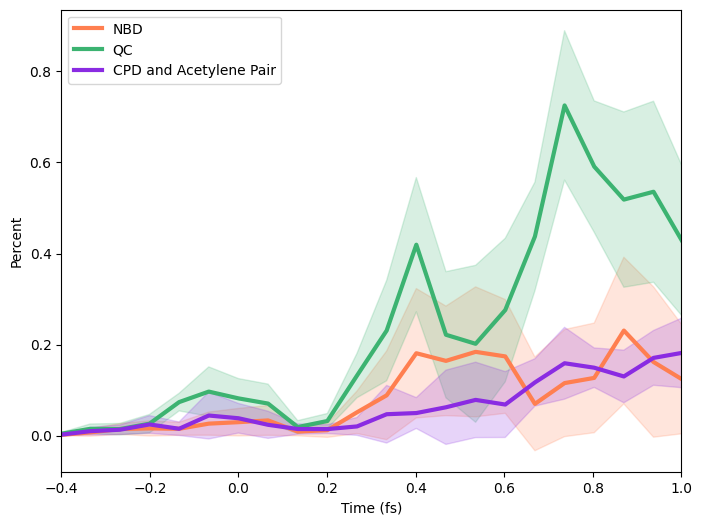

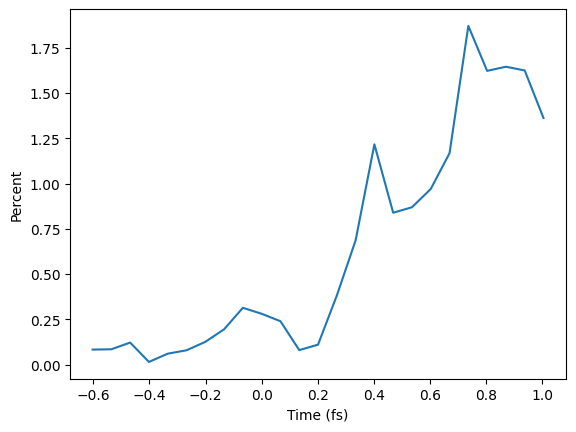

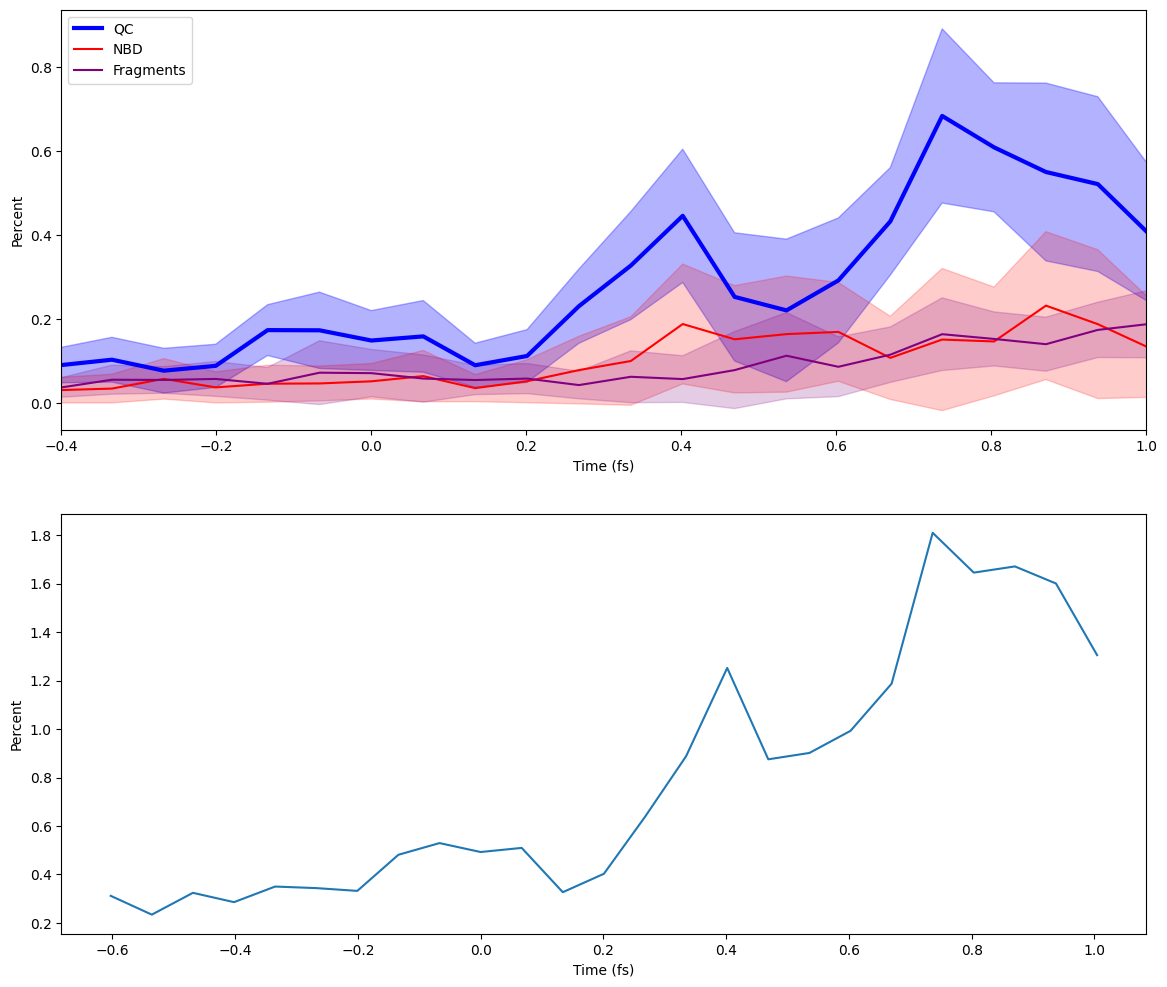

In [63]:
plt.figure(figsize=(8,6))
# plt.subplot(2,1,1)
plt.plot(time_exp[fit_idx], new_pso_percent_NB, color="coral", linewidth=3, label="NBD")
plt.fill_between(time_exp[fit_idx], new_pso_percent_NB-new_pso_std_NB,
                 new_pso_percent_NB+new_pso_std_NB, alpha=0.2, color='coral')
plt.plot(time_exp[fit_idx], new_pso_percent_QC, color='mediumseagreen', linewidth=3, label="QC")
plt.fill_between(time_exp[fit_idx], new_pso_percent_QC - new_pso_std_QC,
                 new_pso_percent_QC+new_pso_std_QC, alpha=0.2, color='mediumseagreen')
plt.plot(time_exp[fit_idx], new_pso_percent_frags, color="blueviolet", linewidth=3, label="CPD and Acetylene Pair")
plt.fill_between(time_exp[fit_idx], new_pso_percent_frags-new_pso_std_frags,
                 new_pso_percent_frags+new_pso_std_frags, alpha=0.2, color='blueviolet')
#plt.plot(time_exp[fit_idx], np.sum((new_pso_percent_NB, new_pso_percent_QC, new_pso_percent_frags), axis=0), color="green", label="total")
plt.legend()
plt.xlabel("Time (fs)")
plt.xlim(-0.4, 1)
plt.ylabel("Percent")

# plt.subplot(2,1,2)
plt.figure()
plt.plot(time_exp[fit_idx], np.array(combined_averages['pso_results']['excitation_perc'])*100)
plt.xlabel("Time (fs)")
plt.ylabel("Percent")
plt.show()

plt.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.plot(time_exp[fit_idx], new_an_percent_QC, color='blue', linewidth=3, label="QC")
plt.fill_between(time_exp[fit_idx], new_an_percent_QC - new_an_std_QC,
                 new_an_percent_QC+new_an_std_QC, alpha=0.3, color='blue')
plt.plot(time_exp[fit_idx], new_an_percent_NB, color="red", label="NBD")
plt.fill_between(time_exp[fit_idx], new_an_percent_NB-new_an_std_NB,
                 new_an_percent_NB+new_an_std_NB, alpha=0.2, color='red')
plt.plot(time_exp[fit_idx], new_an_percent_frags, color="purple", label="Fragments")
plt.fill_between(time_exp[fit_idx], new_an_percent_frags-new_an_std_frags,
                 new_an_percent_frags+new_an_std_frags, alpha=0.2, color='purple')
#plt.plot(time_exp[fit_idx], np.sum((new_an_percent_NB, new_an_percent_QC, new_an_percent_frags), axis=0), color="green", label="total")
plt.legend()
plt.xlim(-0.4,1)
plt.xlabel("Time (fs)")
plt.ylabel("Percent")

plt.subplot(2,1,2)
plt.plot(time_exp[fit_idx], np.array(combined_averages['anneal_results']['excitation_perc'])*100)
plt.xlabel("Time (fs)")
plt.ylabel("Percent")
plt.show()

In [64]:
def calculate_total_std(std_devs):
    """
    Calculate the total standard deviation for multiple datasets with the same sample size.

    Parameters:
        std_devs (list of float): Standard deviations of the datasets.

    Returns:
        float: Total standard deviation.
    """
    if len(std_devs) == 0:
        raise ValueError("std_devs list cannot be empty.")
    
    variance_sum = sum(s ** 2 for s in std_devs)
    total_std_dev = np.sqrt(variance_sum / len(std_devs))
    return total_std_dev

#print(combined_stds['all_results']['fits'])
# ave_fits_std = calculate_total_std(combined_stds['all_results']['fits'])
# print(ave_fits_std.shape)

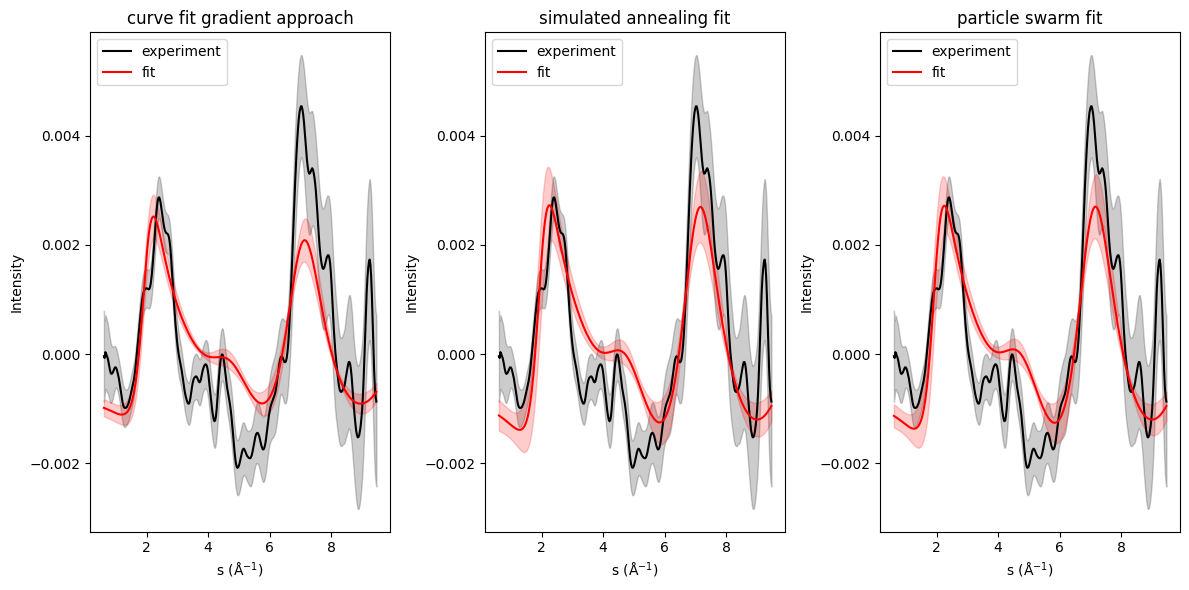

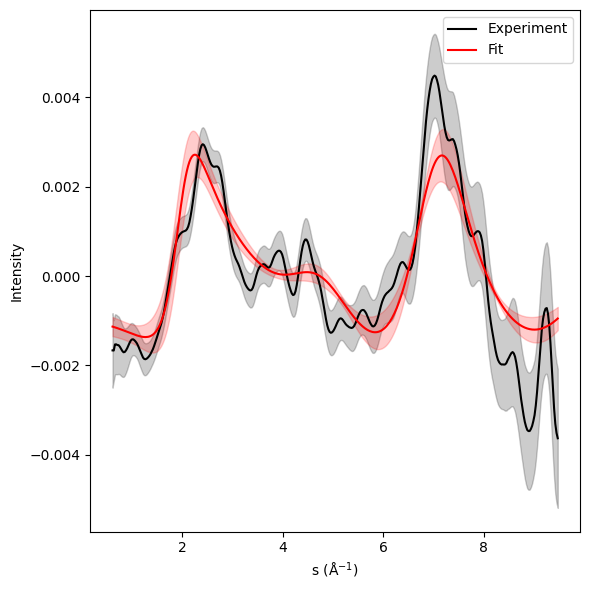

ANNEALING
 percent QC = 0.6264384545761682 +/- 0.21158042829830573 
 percent NBD = 0.18711560441691957 +/- 0.17086037166765972 
 percent fragments = 0.18644594100691228        +/- 0.08726940268391233 
 total percent = 1.0
RMSE = 7.064128178659567e-05
PARTICLE SWARM
 percent QC = 64.92198710943283 +/- 20.068615279020644 
 percent NBD = 16.512165292580697 +/- 16.125165400633502 
 percent fragments = 18.56584759798647        +/- 7.748502167480227 
 total percent = 100.0
RMSE = 6.815959714306259e-05


In [69]:
ave_exp = np.mean(np.nanmean(np.array(dI_I_boot[:, 0:6, :]), axis=1), axis=1)[s_idx]

ave_fits = np.mean(np.array(combined_averages['all_results']['fits'][0:6]), axis=0)
ave_fits_std = calculate_total_std(combined_stds['all_results']['fits'][0:6])

ave_anneal = np.mean(np.array(combined_averages['anneal_results']['fits'][0:6]), axis=0)
ave_anneal_std = calculate_total_std(combined_stds['anneal_results']['fits'][0:6])

ave_pso = np.mean(np.array(combined_averages['pso_results']['fits'][0:6]), axis=0)
ave_pso_std = calculate_total_std(combined_stds['pso_results']['fits'][0:6])


plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_fits, color='r', label="fit")
plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
# plt.axvline(s_min)
# plt.axvline(s_max)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("curve fit gradient approach")
plt.legend()

plt.subplot(1,3,2)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_anneal, color='r', label="fit")
plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("simulated annealing fit")
plt.legend()

plt.subplot(1,3,3)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

ave_anneal_corrected = np.mean(np.array(combined_averages['anneal_results']['corrected_data'][0:6]), axis=0)

ave_pso_corrected = np.mean(np.array(combined_averages['pso_results']['corrected_data'][0:6]), axis=0)



plt.figure(figsize=(6, 6))

# plt.subplot(1,3,1)
# plt.plot(x_data, ave_exp, color='k', label="experiment")
# plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
# plt.plot(x_data, ave_fits, color='r', label="fit")
# plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
# # plt.axvline(s_min)
# # plt.axvline(s_max)
# plt.ylabel("Intensity")
# plt.xlabel(f"s {inv_angs}")
# plt.title("curve fit gradient approach")
# plt.legend()

# plt.subplot(1,2,1)
# plt.plot(x_data, ave_anneal_corrected, color='k', label="experiment")
# plt.fill_between(x_data, ave_anneal_corrected-late_data_std, ave_anneal_corrected+late_data_std, color='k', alpha=0.2)
# plt.plot(x_data, ave_anneal, color='r', label="fit")
# plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
# plt.ylabel("Intensity")
# plt.xlabel(f"s {inv_angs}")
# plt.title("simulated annealing fit")
# plt.legend()

# plt.subplot(1,2,2)
plt.plot(x_data, ave_pso_corrected, color='k', label="Experiment")
plt.fill_between(x_data, ave_pso_corrected-late_data_std, ave_pso_corrected+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="Fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
#plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

ave_perc_QC = np.mean(np.array(combined_averages['all_results']['perc_QC']))
std_perc_QC = calculate_total_std(combined_stds['all_results']['perc_QC'])
ave_perc_NB = np.mean(np.array(combined_averages['all_results']['perc_NB']))
std_perc_NB = calculate_total_std(combined_stds['all_results']['perc_NB'])
ave_perc_frags = np.mean(np.array(combined_averages['all_results']['perc_frags']))
std_perc_frags = calculate_total_std(combined_stds['all_results']['perc_frags'])

ave_anneal_QC = np.mean(np.array(combined_averages['anneal_results']['perc_QC'][0:6]))
std_anneal_QC = calculate_total_std(combined_stds['anneal_results']['perc_QC'][0:6])
ave_anneal_NB = np.mean(np.array(combined_averages['anneal_results']['perc_NB'][0:6]))
std_anneal_NB = calculate_total_std(combined_stds['anneal_results']['perc_NB'][0:6])
ave_anneal_frags = np.mean(np.array(combined_averages['anneal_results']['perc_frags'][0:6]))
std_anneal_frags = calculate_total_std(combined_stds['anneal_results']['perc_frags'][0:6])
# ave_pso_QC = np.mean(pso_perc_QC[good_idx])
# std_pso_QC = np.std(pso_perc_QC[good_idx])
# ave_pso_NB = np.mean(pso_perc_NB[good_idx])
# std_pso_NB = np.std(pso_perc_NB[good_idx])
# ave_pso_frags = np.mean(pso_perc_frag[good_idx])
# std_pso_frags = np.std(pso_perc_frag[good_idx])

# ave_pso_QC = np.mean(new_pso_percent_QC[0:6])*100
# std_pso_QC = calculate_total_std(new_pso_std_QC[0:6])*100
# ave_pso_NB = np.mean(new_pso_percent_NB[0:6])*100
# std_pso_NB = calculate_total_std(new_pso_std_NB[0:6])*100
# ave_pso_frags = np.mean(new_pso_percent_frags[0:6])*100
# std_pso_frags = calculate_total_std(new_pso_std_frags[0:6])*100

ave_pso_QC = np.mean(combined_averages['pso_results']['perc_QC'][0:6])*100
std_pso_QC = calculate_total_std(combined_stds['pso_results']['perc_QC'][0:6])*100
ave_pso_NB = np.mean(combined_averages['pso_results']['perc_NB'][0:6])*100
std_pso_NB = calculate_total_std(combined_stds['pso_results']['perc_NB'][0:6])*100
ave_pso_frags = np.mean(combined_averages['pso_results']['perc_frags'][0:6])*100
std_pso_frags = calculate_total_std(combined_stds['pso_results']['perc_frags'][0:6])*100


# print("CURVE FIT")
# print(f" percent QC = {ave_perc_QC} +/- {std_perc_QC} \n percent NBD = {ave_perc_NB} +/- {std_perc_NB} \n percent fragments = {ave_perc_frags} \
#       +/- {std_perc_frags} \n total percent = {ave_perc_QC+ave_perc_NB+ave_perc_frags}")
# rmse = np.sqrt(np.nanmean(ave_exp-ave_fits)**2)
# print(f"RMSE = {rmse}")
print("ANNEALING")
print(f" percent QC = {ave_anneal_QC} +/- {std_anneal_QC} \n percent NBD = {ave_anneal_NB} +/- {std_anneal_NB} \n percent fragments = {ave_anneal_frags} \
       +/- {std_anneal_frags} \n total percent = {ave_anneal_QC+ave_anneal_NB+ave_anneal_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_anneal)**2)
print(f"RMSE = {rmse}")
print("PARTICLE SWARM")
print(f" percent QC = {ave_pso_QC} +/- {std_pso_QC} \n percent NBD = {ave_pso_NB} +/- {std_pso_NB} \n percent fragments = {ave_pso_frags} \
       +/- {std_pso_frags} \n total percent = {ave_pso_QC+ave_pso_NB+ave_pso_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_pso)**2)
print(f"RMSE = {rmse}")

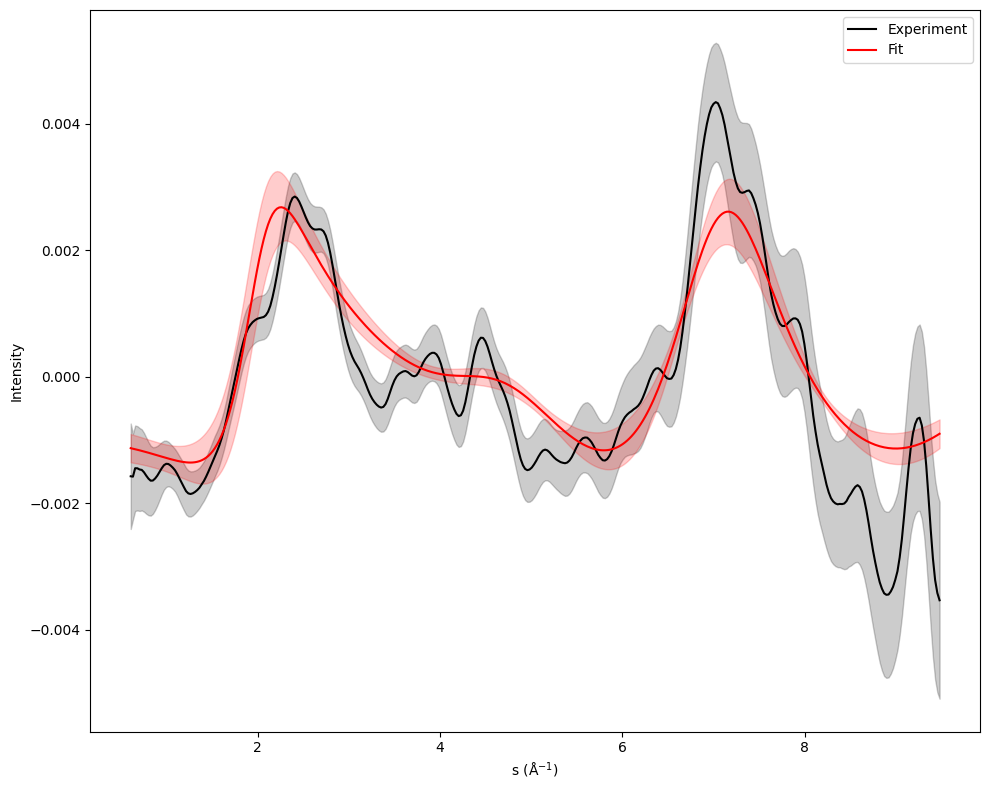

In [59]:
plt.figure(figsize=(10,8))
plt.plot(x_data, ave_pso_corrected, color='k', label="Experiment")
plt.fill_between(x_data, ave_pso_corrected-late_data_std, ave_pso_corrected+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="Fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
#plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

## Fitting Average of Late Data

In [37]:
all_results = {
    "perc_QC": [],
    "perc_NB": [],
    "perc_frags": [],
    "fits": [],
    "rmse": [],
    "chi_sq": [],
}

anneal_results = {
    "perc_QC": [],
    "perc_NB": [],
    "perc_frags": [],
    "fits": [],
    "rmse": [],
    "chi_sq": [],
    "corrected_data": [],
    "fails": []
}

pso_results = {
    "perc_QC": [],
    "perc_NB": [],
    "perc_frags": [],
    "fits": [],
    "rmse": [],
    "chi_sq": [],
    "corrected_data": [],
    "fails": []
}
#late_data = np.array(np.nanmean(dI_I_boot[:, 0:6, :], axis=1))
late_data = np.nanmean(np.array(dI_I_boot[:, 0:6, :]), axis=1)


for j in range(0, 100):
    y_data = late_data[s_idx, j]

    bounds = ([0, 0, 0], [0.01, 0.01, 0.01])
    #Fit the data using curve_fit
    print("Results from Basic Curve Fit \n")
    popt, pcov = curve_fit(model, x_data, y_data, sigma=late_data_std, bounds=bounds)

    perc_QC = (popt[0]/(popt[0]+popt[1]+popt[2]))*100
    perc_NB = (popt[1]/(popt[0]+popt[1]+popt[2]))*100
    perc_frags = (popt[2]/(popt[0]+popt[1]+popt[2]))*100

    perc_fit_line = model(x_data, *popt)

    all_results['perc_QC'].append(perc_QC)
    all_results['perc_NB'].append(perc_NB)
    all_results['perc_frags'].append(perc_frags)
    all_results['fits'].append(perc_fit_line)

    rmse = np.sqrt(np.nanmean(y_data-perc_fit_line)**2)
    all_results['rmse'].append(rmse)
    chi_sq = np.sum(((y_data-perc_fit_line)**2)/(late_data_std**2))
    all_results['chi_sq'].append(chi_sq)

    print(f"RMSE for run {j} = {rmse}, chi^2 = {chi_sq}")
    # Print the optimal parameters
    # print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags}")

    print("Results from Dual Annealing \n")
    bounds = [(0,0.05), (0,0.05), (0,0.05)]
    result = dual_annealing(zero_fit_cost_func, bounds=bounds, args=(x_data, y_data, late_data_std), no_local_search=True)
    sa_params = result.x
    print(result.message)
    if result.nit == 1000:
        anneal_results['fails'].append(1)
    else:
        anneal_results['fails'].append(0)

    perc_QC = (sa_params[0]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_NB = (sa_params[1]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_frags = (sa_params[2]/(sa_params[0]+sa_params[1]+sa_params[2]))*100

    perc_fit_line = model(x_data, *sa_params)

    anneal_results['perc_QC'].append(perc_QC)
    anneal_results['perc_NB'].append(perc_NB)
    anneal_results['perc_frags'].append(perc_frags)
    anneal_results['fits'].append(perc_fit_line)

    _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
    anneal_results['corrected_data'].append(corrected_data)

    rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)
    anneal_results['rmse'].append(rmse)
    chi_sq = np.sum(((corrected_data-perc_fit_line)**2)/(late_data_std**2))
    anneal_results['chi_sq'].append(chi_sq)

    # rmse = np.sqrt(np.nanmean(y_data-perc_fit_line)**2)
    # anneal_rmse.append(rmse)
    # chi_sq = np.sum(((y_data-perc_fit_line)**2)/(late_data_std**2))
    # anneal_chi_sq.append(chi_sq)

    print(f"RMSE for run {j} = {rmse}, chi^2 = {chi_sq}")
    # Print the optimal parameters
    # print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags}")

    print("Results from Differential Evolution \n")
    bounds = [(0,0.05), (0,0.05), (0,0.05)]
    result = differential_evolution(zero_fit_cost_func, bounds=bounds, args=(x_data, y_data, late_data_std), maxiter=1000)
    sa_params = result.x
    print(result.message)
    if result.nit == 1000:
        pso_results['fails'].append(1)
    else:
        pso_results['fails'].append(0)

    perc_QC = (sa_params[0]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_NB = (sa_params[1]/(sa_params[0]+sa_params[1]+sa_params[2]))*100
    perc_frags = (sa_params[2]/(sa_params[0]+sa_params[1]+sa_params[2]))*100


    perc_fit_line = model(x_data, *sa_params)

    pso_results['perc_QC'].append(perc_QC)
    pso_results['perc_NB'].append(perc_NB)
    pso_results['perc_frags'].append(perc_frags)
    pso_results['fits'].append(perc_fit_line)

    _, corrected_data = zero_correction(x_data, ave_data, perc_fit_line)
    pso_results['corrected_data'].append(corrected_data)

    chi_sq = np.sum(((corrected_data-perc_fit_line)**2)/(late_data_std**2))
    pso_results['chi_sq'].append(chi_sq)
    rmse = np.sqrt(np.nanmean(corrected_data-perc_fit_line)**2)
    pso_results['rmse'].append(rmse)

    # chi_sq = np.sum(((y_data-perc_fit_line)**2)/(late_data_std**2))
    # pso_chi_sq.append(chi_sq)
    # rmse = np.sqrt(np.nanmean(y_data-perc_fit_line)**2)
    # pso_rmse.append(rmse)

    print(f"RMSE for data {j} = {rmse}, chi^2 = {chi_sq}")
    # Print the optimal parameters
    # print(f" percent QC = {perc_QC} \n percent NBD = {perc_NB} \n percent fragments = {perc_frags} \n total percent = {perc_QC+perc_NB+perc_frags}")

ave_exp = np.nanmean(late_data, axis=1)[s_idx]
print(ave_exp.shape)


Results from Basic Curve Fit 

RMSE for run 0 = 0.00027203813366592035, chi^2 = 1429.4271373335778
Results from Dual Annealing 

['Maximum number of iteration reached']
RMSE for run 0 = 7.59159289131841e-06, chi^2 = 1250.6195554493534
Results from Differential Evolution 

Optimization terminated successfully.
RMSE for data 0 = 1.5098888900014586e-05, chi^2 = 1280.7787643965337
Results from Basic Curve Fit 

RMSE for run 1 = 5.662897668404863e-05, chi^2 = 1314.3132871289667
Results from Dual Annealing 

['Maximum number of iteration reached']
RMSE for run 1 = 0.0003274137518597349, chi^2 = 961.3665651286375
Results from Differential Evolution 

Optimization terminated successfully.
RMSE for data 1 = 0.0002935106352592446, chi^2 = 885.3457707149714
Results from Basic Curve Fit 

RMSE for run 2 = 0.0002658985384005559, chi^2 = 1580.123586660697
Results from Dual Annealing 

['Maximum number of iteration reached']
RMSE for run 2 = 0.0002595832999262291, chi^2 = 837.2089441458475
Results fr

In [38]:
#pso_results['chi_sq']
pso_chi_sq = np.array(pso_results['chi_sq'])/(len(ave_data)-3)
anneal_chi_sq = np.array(anneal_results['chi_sq'])/(len(ave_data)-3)
all_chi_sq = np.array(all_results['chi_sq'])/(len(ave_data)-3)


In [39]:
print(np.std(pso_chi_sq))
good_idx = np.where((pso_chi_sq > (np.mean(pso_chi_sq - np.std(pso_chi_sq)))) & (pso_chi_sq < (np.mean(pso_chi_sq + np.std(pso_chi_sq)))))[0]
print(len(good_idx), len(pso_chi_sq))

0.567237344836873
86 100


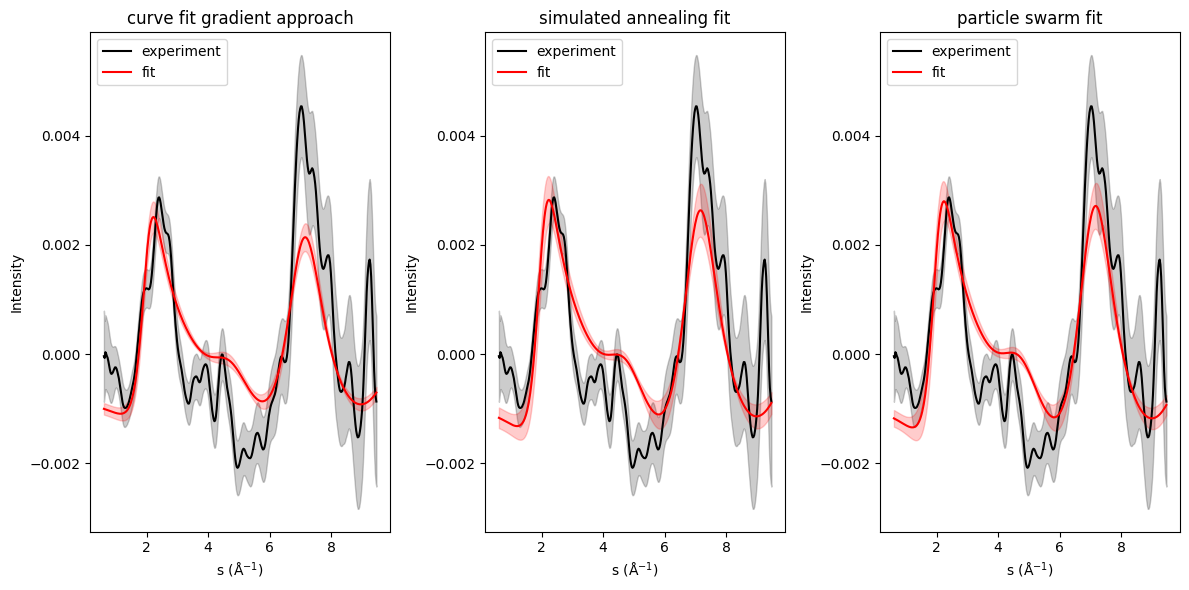

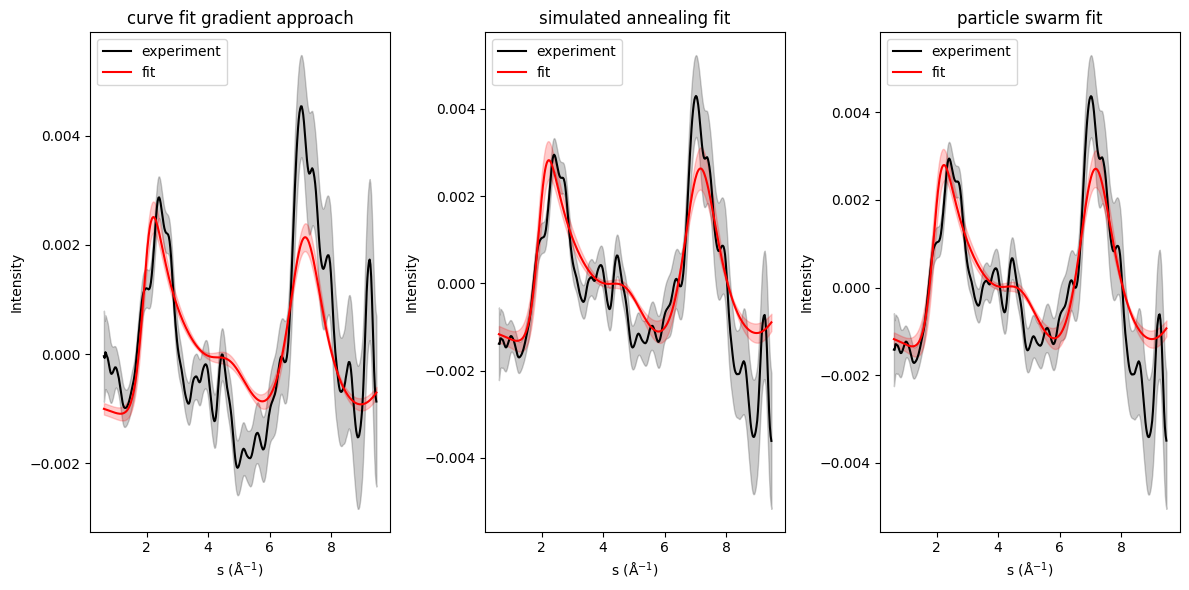

CURVE FIT
 percent QC = 47.98473647372572 +/- 27.836085315405484 
 percent NBD = 28.024927461563138 +/- 23.98381095763465 
 percent fragments = 23.99033606471114       +/- 5.269568096970885 
 total percent = 100.0
RMSE = 6.784497687588918e-05
ANNEALING
 percent QC = 60.314675164793435 +/- 20.971847971434865 
 percent NBD = 18.444848632702925 +/- 17.58376649759759 
 percent fragments = 21.24047620250363        +/- 6.101360552933199 
 total percent = 99.99999999999999
RMSE = 5.319650480174854e-05
PARTICLE SWARM
 percent QC = 66.19256324356253 +/- 20.922594264857157 
 percent NBD = 13.740554912101022 +/- 17.317149462414758 
 percent fragments = 20.066881844336443        +/- 6.070152181245535 
 total percent = 100.0
RMSE = 5.4559444467390393e-05


In [40]:
plt.figure(figsize=(12,6))

ave_fits = np.mean(np.array(all_results['fits']), axis=0)
ave_fits_std = np.std(np.array(all_results['fits']), axis=0)

ave_anneal = np.mean(np.array(anneal_results['fits']), axis=0)
ave_anneal_std = np.std(np.array(anneal_results['fits']), axis=0)

ave_pso = np.mean(np.array(pso_results['fits']), axis=0)
ave_pso_std = np.std(np.array(pso_results['fits']), axis=0)

plt.subplot(1,3,1)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_fits, color='r', label="fit")
plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
# plt.axvline(s_min)
# plt.axvline(s_max)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("curve fit gradient approach")
plt.legend()

plt.subplot(1,3,2)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_anneal, color='r', label="fit")
plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("simulated annealing fit")
plt.legend()

plt.subplot(1,3,3)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

ave_anneal_corrected = np.mean(np.array(anneal_results['corrected_data']), axis=0)
std_anneal_corrected = np.std(np.array(anneal_results['corrected_data']), axis=0)
ave_pso_corrected = np.mean(np.array(pso_results['corrected_data']), axis=0)
std_pso_corrected = np.std(np.array(pso_results['corrected_data']), axis=0)


plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_fits, color='r', label="fit")
plt.fill_between(x_data, ave_fits-ave_fits_std, ave_fits+ave_fits_std, color='r', alpha=0.2)
# plt.axvline(s_min)
# plt.axvline(s_max)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("curve fit gradient approach")
plt.legend()

plt.subplot(1,3,2)
plt.plot(x_data, ave_anneal_corrected, color='k', label="experiment")
plt.fill_between(x_data, ave_anneal_corrected-late_data_std, ave_anneal_corrected+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_anneal, color='r', label="fit")
plt.fill_between(x_data, ave_anneal-ave_anneal_std, ave_anneal+ave_anneal_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("simulated annealing fit")
plt.legend()

plt.subplot(1,3,3)
plt.plot(x_data, ave_pso_corrected, color='k', label="experiment")
plt.fill_between(x_data, ave_pso_corrected-late_data_std, ave_pso_corrected+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_pso, color='r', label="fit")
plt.fill_between(x_data, ave_pso-ave_pso_std, ave_pso+ave_pso_std, color='r', alpha=0.2)
plt.ylabel("Intensity")
plt.xlabel(f"s {inv_angs}")
plt.title("particle swarm fit")
plt.legend()
plt.tight_layout()

plt.show()

ave_perc_QC = np.mean(np.array(all_results['perc_QC']))
std_perc_QC = np.std(np.array(all_results['perc_QC']))
ave_perc_NB = np.mean(np.array(all_results['perc_NB']))
std_perc_NB = np.std(np.array(all_results['perc_NB']))
ave_perc_frags = np.mean(np.array(all_results['perc_frags']))
std_perc_frags = np.std(np.array(all_results['perc_frags']))

ave_anneal_QC = np.mean(np.array(anneal_results['perc_QC']))
std_anneal_QC = np.std(np.array(anneal_results['perc_QC']))
ave_anneal_NB = np.mean(np.array(anneal_results['perc_NB']))
std_anneal_NB = np.std(np.array(anneal_results['perc_NB']))
ave_anneal_frags = np.mean(np.array(anneal_results['perc_frags']))
std_anneal_frags = np.std(np.array(anneal_results['perc_frags']))

# ave_pso_QC = np.mean(pso_perc_QC[good_idx])
# std_pso_QC = np.std(pso_perc_QC[good_idx])
# ave_pso_NB = np.mean(pso_perc_NB[good_idx])
# std_pso_NB = np.std(pso_perc_NB[good_idx])
# ave_pso_frags = np.mean(pso_perc_frag[good_idx])
# std_pso_frags = np.std(pso_perc_frag[good_idx])

ave_pso_QC = np.mean(np.array(pso_results['perc_QC']))
std_pso_QC = np.std(np.array(pso_results['perc_QC']))
ave_pso_NB = np.mean(np.array(pso_results['perc_NB']))
std_pso_NB = np.std(np.array(pso_results['perc_NB']))
ave_pso_frags = np.mean(np.array(pso_results['perc_frags']))
std_pso_frags = np.std(np.array(pso_results['perc_frags']))

print("CURVE FIT")
print(f" percent QC = {ave_perc_QC} +/- {std_perc_QC} \n percent NBD = {ave_perc_NB} +/- {std_perc_NB} \n percent fragments = {ave_perc_frags} \
      +/- {std_perc_frags} \n total percent = {ave_perc_QC+ave_perc_NB+ave_perc_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_fits)**2)
print(f"RMSE = {rmse}")
print("ANNEALING")
print(f" percent QC = {ave_anneal_QC} +/- {std_anneal_QC} \n percent NBD = {ave_anneal_NB} +/- {std_anneal_NB} \n percent fragments = {ave_anneal_frags} \
       +/- {std_anneal_frags} \n total percent = {ave_anneal_QC+ave_anneal_NB+ave_anneal_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_anneal)**2)
print(f"RMSE = {rmse}")
print("PARTICLE SWARM")
print(f" percent QC = {ave_pso_QC} +/- {std_pso_QC} \n percent NBD = {ave_pso_NB} +/- {std_pso_NB} \n percent fragments = {ave_pso_frags} \
       +/- {std_pso_frags} \n total percent = {ave_pso_QC+ave_pso_NB+ave_pso_frags}")
rmse = np.sqrt(np.nanmean(ave_exp-ave_pso)**2)
print(f"RMSE = {rmse}")

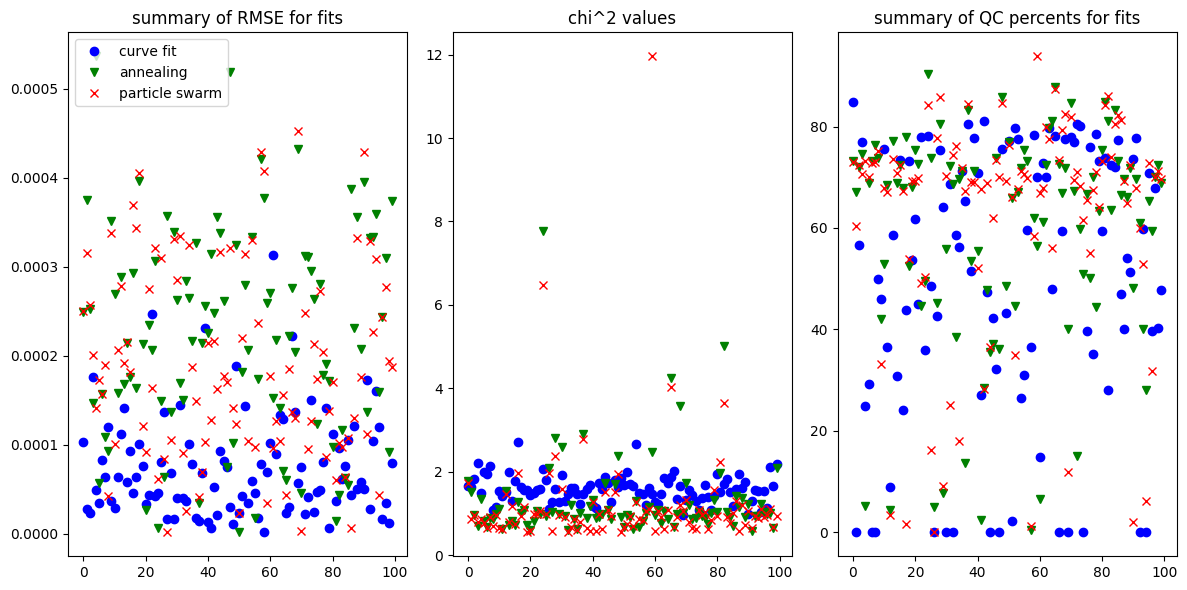

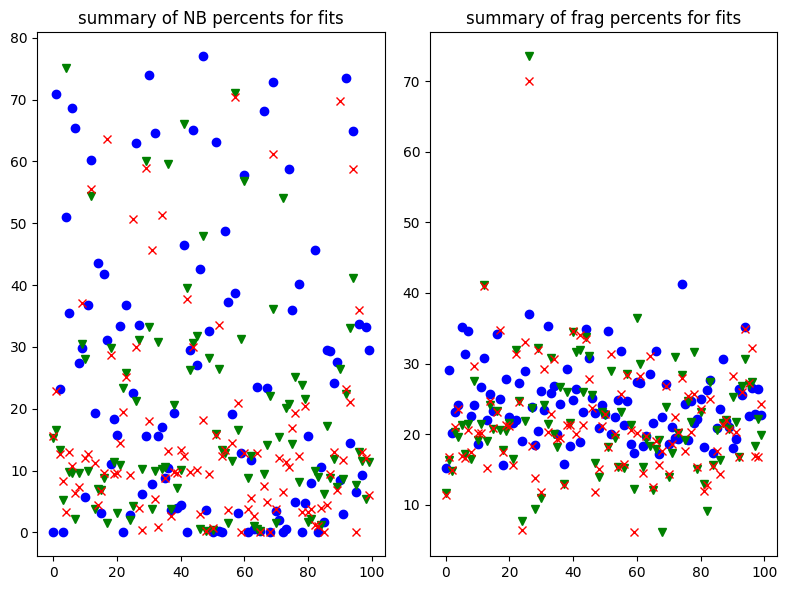

In [69]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.plot(all_rmse, "o", color="b", label="curve fit")
plt.plot(anneal_rmse, "v", color="green", label="annealing")
plt.plot(pso_rmse, "x", color="r", label="particle swarm")
plt.title("summary of RMSE for fits")
plt.legend(loc="upper left")

plt.subplot(1,3,2)
plt.plot(all_chi_sq, "o", color='b', label="curve fit")
plt.plot(anneal_chi_sq, "v", color='green', label="annealing")
plt.plot(pso_chi_sq, "x", color="r", label="particle swarm")
# plt.yscale('log')
plt.title("chi^2 values")

plt.subplot(1,3,3)
plt.plot(all_perc_QC, "o", color="b", label="curve fit")
plt.plot(anneal_perc_QC, "v", color="green", label="annealing")
plt.plot(pso_perc_QC, "x", color="r", label="particle swarm")
plt.title("summary of QC percents for fits")
#plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(all_perc_NB, "o", color="b", label="curve fit")
plt.plot(anneal_perc_NB, "v", color="green", label="annealing")
plt.plot(pso_perc_NB, "x", color="r", label="particle swarm")
plt.title("summary of NB percents for fits")
#plt.legend()

plt.subplot(1,2,2)
plt.plot(all_perc_frags, "o", color="b", label="curve fit")
plt.plot(anneal_perc_frag, "v", color="green", label="annealing")
plt.plot(pso_perc_frag, "x", color="r", label="particle swarm")
plt.title("summary of frag percents for fits")
#plt.legend()
plt.tight_layout()
plt.show()



(100, 412)


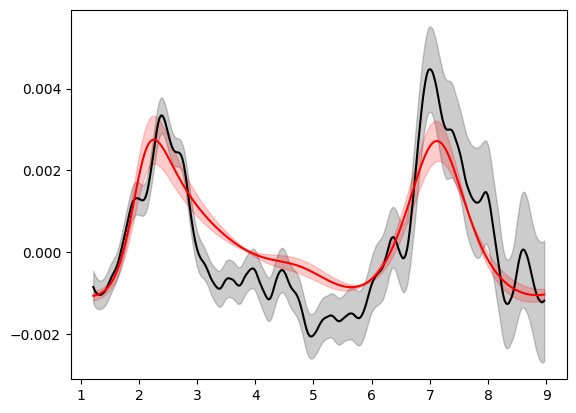

 percent QC = 30.046676121992398 +/- 26.863315361663748 
 percent NBD = 48.12769200963532 +/- 25.12037049726148       
 percent fragments = 21.825631868372277 +/- 4.20839696589242
RMSE = 0.0001477908870666494


In [74]:
matlab_fits = fit_params['dI_I_end_array']
print(matlab_fits.shape)
perc_QC_mat = fit_params['perc_QD_array']
std_perc_QC_mat = np.std(fit_params['perc_QD_array'])
perc_NB_mat = fit_params['perc_NB_array']
std_perc_NB_mat = np.std(fit_params['perc_NB_array'])
perc_frags_mat = fit_params['perc_frag_array']
std_perc_frags_mat = np.std(fit_params['perc_frag_array'])

ave_mat_fit = np.mean(matlab_fits, axis=0)[50:370]/100
std_mat_fit = np.std(matlab_fits, axis=0)[50:370]/100



plt.figure()
plt.plot(x_data, ave_exp, color='k', label="experiment")
plt.fill_between(x_data, ave_exp-late_data_std, ave_exp+late_data_std, color='k', alpha=0.2)
plt.plot(x_data, ave_mat_fit, color='r', label='fit')
plt.fill_between(x_data, ave_mat_fit-std_mat_fit, ave_mat_fit+std_mat_fit, color='r', alpha=0.2)
plt.show()

print(f" percent QC = {np.mean(perc_QC_mat)*100} +/- {std_perc_QC_mat*100} \n percent NBD = {np.mean(perc_NB_mat)*100} +/- {std_perc_NB_mat*100} \
      \n percent fragments = {np.mean(perc_frags_mat)*100} +/- {std_perc_frags_mat*100}")

rmse = np.sqrt(np.nanmean(ave_exp-ave_mat_fit)**2)
print(f"RMSE = {rmse}")

# X-Ray Data Analysis 

In [37]:
f1 = 'QD_ps_run187to192_scaled.npz'
#This unpacks everything from the small data file produced in the processor script
hf1 = np.load(f1)
for item in hf1:
	print(item)
	exec('%s = np.array(hf1[item])' %str(item))
    
# print(errors.shape)
# print(ibpdiffs.shape)
# print(q_bins.shape)
# print(error_rapdiffs.shape)
# print(error_aapdiffs.shape)
# print(aapdiffs.shape)
# print(time_bins.shape)
# print(phi_bins.shape)
# print(rapdiffs.shape)
print('task complete')

errors
ibpdiffs
raons
q_bins
error_rapdiffs
error_aapdiffs
aapdiffs
time_bins
phi_bins
raoffs
rapdiffs
task complete


## Apply Moving Average

In [38]:
sz = np.shape(raons) # sz[0] - size of qbins , sz[1] - size of tbins

rapdiffs_movmean = np.zeros((sz[0],sz[1]))

for i in range(0,sz[1]):
     rapdiffs_movmean[:,i] = pd.Series(rapdiffs[:,i]).rolling(window=3,axis=0).mean()

C:\Users\laure\AppData\Local\Temp\ipykernel_26948\2247553891.py:6: FutureWarning: The 'axis' keyword in Series.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  rapdiffs_movmean[:,i] = pd.Series(rapdiffs[:,i]).rolling(window=3,axis=0).mean()


## Plot 1D Q Lineouts

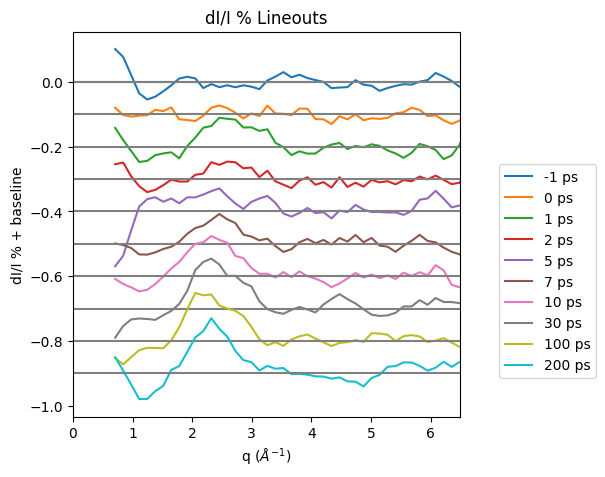

In [40]:
plt.figure(figsize=(5,5))
#for i in range(0, rapdiffs[0,:].size):
b = 0
j = 0   
#for i in range(1,2):
for i in [0,1,2,3,6,8,11,12,13,14]:
    j +=  1
    #plt.errorbar(q_bins,(rapdiffs_movmean[:,i]) + b, yerr = error_rapdiffs[:,i], label = '%0.0f ps' % time_bins[i]) 
    plt.plot(q_bins,(rapdiffs_movmean[:,i]) + b, label = '%0.0f ps' % time_bins[i])
    plt.axhline(y=b,color='grey')
    b += -0.1
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('dI/I % + baseline')
plt.title('dI/I % Lineouts')
plt.xlim([0,6.5])
#plt.ylim([-0.05,0.05])
plt.axhline(y=0, color='grey')
#plt.legend(loc='best')
plt.legend(loc=(1.1,0.1))
plt.show()
#plt.savefig('CHD_radial_average.png')

## Plotting Smoothed Experimental Data

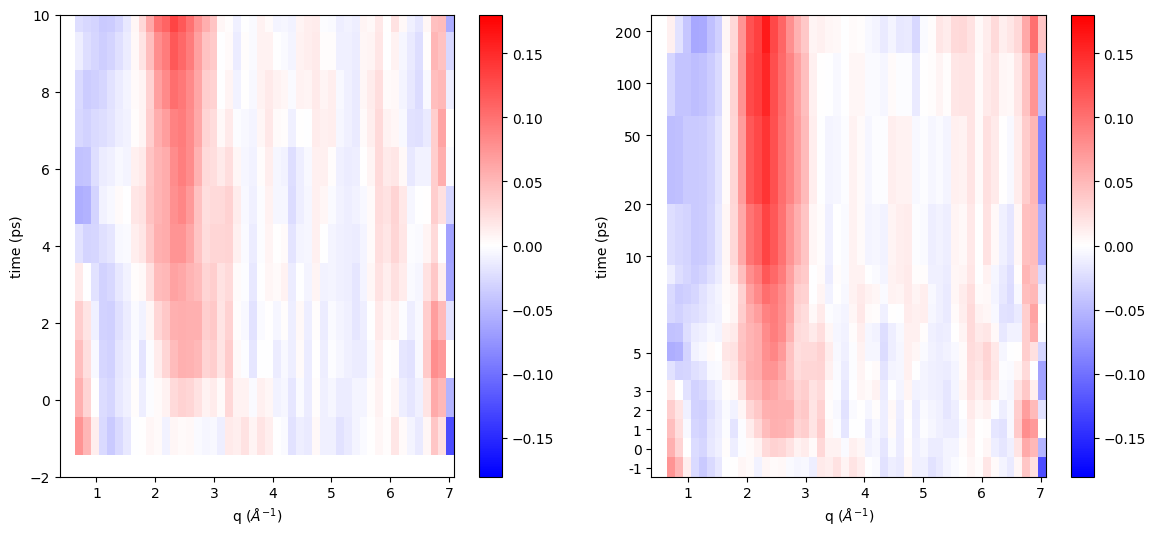

In [44]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('time (ps)')
#plt.title('dI/I: QC, moving average applied in q and Gaussian filter in time')
plt.pcolormesh(q_bins,time_bins,(gf(rapdiffs_movmean,(0,1))).T, cmap = 'bwr')
#plt.pcolormesh( q_bins,time_bins, np.transpose( gf(rapdiffs_movmean,(0,1))), cmap = 'bwr')
plt.clim(-0.18, 0.18)
# plt.xlim([-2, 20])
plt.ylim(-2,10)
#plt.yticks([0,25,50,75,100,125,150])
#plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.colorbar()

plt.subplot(1,2,2)
plt.xlabel('q ($\AA^{-1}$)')
plt.ylabel('time (ps)')
#plt.title('dI/I: QC, moving average applied in q and Gaussian filter in time')
plt.pcolormesh(q_bins,time_bins,(gf(rapdiffs_movmean,(0,1))).T, cmap = 'bwr')
plt.clim(-0.18, 0.18)
# plt.xlim([-2, 20])
plt.yscale('symlog', linthresh=10)
custom_ticks = [-1, 0, 1, 2, 3, 5, 10, 20, 50, 100, 200]  # Add ticks between 0 and 10
plt.yticks(custom_ticks, labels=custom_ticks)
plt.colorbar()
plt.show()


# Old Stuff

## Look at only slow data

In [35]:
NB_slow_ids = []
NB_slow_CIs = []
NB_slow_dIs = []
NB_slow_groups =[]

QC_slow_ids = []
QC_slow_CIs = []
QC_slow_dIs = []
QC_slow_groups =[]

In [ ]:
print(len(NB_slow_CIs))
print(len(QC_slow_CIs))

0
0


In [ ]:
for key in NB_s4_traj.keys():
    if NB_s4_traj[key]["CI_time"] > 300:
        dI_I = NB_s4_traj[key]["dI_I_raw"].T
        NB_slow_ids.append(key)
        NB_slow_dIs.append(dI_I)
        NB_slow_CIs.append(NB_s4_traj[key]["CI_time"])
        NB_slow_groups.append("s4")

for key in QC_s4_traj.keys():
    if QC_s4_traj[key]["CI_time"] > 300:
        dI_I = QC_s4_traj[key]["dI_I_raw"].T
        QC_slow_ids.append(key)
        QC_slow_dIs.append(dI_I)
        QC_slow_CIs.append(QC_s4_traj[key]["CI_time"])
        QC_slow_groups.append("s4")    


In [ ]:
# QC_slow_dI_mean = np.mean(np.array(QC_slow_dIs), axis=0)
# NB_slow_dI_mean = np.mean(np.array(NB_slow_dIs), axis=0)

# NB_slow_feat1 = np.mean(NB_slow_dI_mean[np.where((s_simu> 7) & (s_simu < 8))[0]], axis=0)
# QC_slow_feat1 = np.mean(QC_slow_dI_mean[np.where((s_simu >7) & (s_simu < 8))[0]], axis=0)
# print(NB_slow_feat1.shape)
# print(QC_slow_feat1.shape)

# plt.figure()
# plt.plot(time_exp*1000, dI_I_feat1*50, "-o", color='k', label="Experiment")
# plt.plot(time_vals, NB_slow_feat1, label="NB like")
# plt.plot(time_vals, QC_slow_feat1, label="QC_like")
# plt.xlabel("Time (fs)")
# plt.ylabel("Intensity")
# plt.title("s3 Slow Trajectories")
# plt.legend()
# plt.show()


In [ ]:
# Define the error function using scipy.special.erf
# def error_function(t, a, t0, sigma, offset):
#     return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset

# # Define bounds for the parameters [amplitude, t0, sigma, offset]
# bounds = ([-1, -0.5, 0, -0.1], [1, 1, 1.5, 0.1])  # lower bounds, upper bounds
# guesses = [0.01, 0.5, 0.5, 0.0]

# # Open a text file to log the results

# log_file = f'{group_name}_fit_results.txt'  # Text file to store fit results
# with open(log_file, 'a') as log:
    
#     # Write the header row only if the file is empty
#     if log.tell() == 0:
#         log.write("Run_Number\tt_0\t\tt_error\tsigma\tsigma_error\toffset\n")

#     # Open the HDF5 file for saving fit_line data
#     with h5py.File(file_name, 'a') as f:
        
#         for key in s2_trajectories.keys():
#             data = s2_trajectories[key]["dI_I_conv"].T
#             time_vals = s2_trajectories[key]["time"]
#             mean_data = np.mean(np.abs(data), axis=0)  # average the absolute value of all the data across s range
            
#             # Fit absolute value of all data
#             popt, pcov = scipy.optimize.curve_fit(error_function, time_vals, mean_data, p0=guesses, bounds=bounds)
#             A, t0, sigma, offset = popt
#             t0_error = np.sqrt(pcov[1, 1])
#             sigma_error = np.sqrt(pcov[2, 2])
            
#             # Write the fitting results to the text file in tab-separated format
#             log.write(f"{key}\t{t0:.4f}\t{t0_error:.3f}\t{sigma:.4f}\t{sigma_error:.3f}\t{offset:.4f}\n")
#             print(f"{key}\t{t0:.4f}\t{t0_error:.3f}\t{sigma:.4f}\t{sigma_error:.3f}\t{offset:.4f}\n")
#             print(f"Run {key} results written to file.")
            
#             # Generate the fit line
#             fit_line = error_function(time_vals, A, t0, sigma, offset)
            
#             # Navigate to the group in the HDF5 file (create if not exists)
#             if group_name not in f:
#                 group = f.create_group(group_name)
#             else:
#                 group = f[group_name]
            
#             # Check if the dataset already exists and overwrite it
#             dataset_name = f"fit_line_run_{key}"
#             if dataset_name in group:
#                 print(f"Overwriting dataset '{dataset_name}'")
#                 del group[dataset_name]
            
#             # Create the dataset for the fit_line
#             group.create_dataset(dataset_name, data=fit_line)
#             print(f"Fit line for run {key} saved successfully.")

